# Sample Integration Method Benchmarking

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of AI for Health (AIH), Talavera-López Lab
- **Date of Creation:** 20.01.2023
- **Date of Last Modification:** 14.03.2024

## 1. Setup

### 1.1 Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../utils")

In [3]:
import argparse
import os
import gc
import pickle
import random
import shutil
import warnings
from copy import deepcopy
from datetime import datetime

import anndata as ad
import cellcharter as cc
import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plottable
import scanpy as sc
import scipy.sparse as sp
import scvi
import seaborn as sns
import squidpy as sq
import torch
from GraphST import GraphST
from matplotlib import gridspec
from matplotlib.pyplot import rc_context
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
from plottable.formatters import tickcross
from plottable.plots import bar
from sklearn.decomposition import KernelPCA

from benchmarking_utils import *

/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
[rank: 0] Global seed set to 0
/home/aih/sebastian.birk/.local/lib/python3.9/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/aih/sebastian.birk/.local/lib/python3.9/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypath

### 1.2 Define Parameters

In [4]:
metric_cols_sample_integration = [
    "cas", "mlami", # global spatial conservation
    "clisis", "gcs", # local spatial conservation
    "nasw", "cnmi", # niche coherence
    "blisi", "pcr" # batch correction
]
metric_col_weights_sample_integration = [ # separate for each category (later multiplied with category_col_weights)
    (1/2), (1/2), # global spatial conservation
    (1/2), (1/2), # local spatial conservation
    1, 1, # niche coherence
    1, 1, # batch correction
]
metric_col_titles_sample_integration = [
    "CAS", # "Cell Type Affinity Similarity",
    "MLAMI", # "Maximum Leiden Adjusted Mutual Info",
    "CLISIS", # "Cell Type Local Inverse Simpson's Index Similarity",
    "GCS", # "Graph Connectivity Similarity",
    "NASW", # "Niche Average Silhouette Width",
    "CNMI", # "Cell Type Normalized Mutual Info",
    "BLISI", # "Batch Local Inverse Simpson's Index"
    "PCR" # "Principal Component Regression"
]
metric_cols_single_sample = metric_cols_sample_integration[:-3]
metric_col_weights_single_sample = metric_col_weights_sample_integration[:-3]
metric_col_titles_single_sample = metric_col_titles_sample_integration[:-3]

category_cols_sample_integration = [
    "Global Spatial Conservation Score",
    "Local Spatial Conservation Score",
    "Niche Coherence Score",
    "Batch Correction Score"]
category_col_weights_sample_integration = [
    1,
    1,
    2,
    2]
category_col_titles_sample_integration = [
    "Global Spatial Conservation Score",
    "Local Spatial Conservation Score",
    "Niche Coherence Score",
    "Batch Correction Score"]
category_col_weights_single_sample = category_col_weights_sample_integration[:-1]
category_cols_single_sample = category_cols_sample_integration[:-1]
category_col_titles_single_sample = [
    "Global Spatial Conservation Score",
    "Local Spatial Conservation Score",
    "Niche Coherence Score"]

### 1.3 Run Notebook Setup

In [5]:
sc.set_figure_params(figsize=(6, 6))
sns.set_style("whitegrid", {'axes.grid' : False})

In [6]:
# Ignore future warnings and user warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [7]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths and Create Directories

In [8]:
data_folder_path = "../../datasets/srt_data/gold"
artifact_folder_path = f"../../artifacts"
benchmarking_folder_path = f"{artifact_folder_path}/sample_integration_method_benchmarking"

## 2. Method Benchmarking

- Run all model notebooks in the ```notebooks/sample_integration_method_benchmarking``` directory before continuing.

### 2.1 Retrieve NicheCompass Runs

#### 2.1.1 seqFISH Mouse Organogenesis

#### 2.1.2 seqFISH Mouse Organogenesis Imputed

#### 2.1.3 nanoString CosMx SMI Human Non-Small-Cell Lung Cancer (NSCLC)

##### 2.1.3.2 Fix Observation Uniqueness

##### 2.1.3.3 Metrics Computation Split Due to Memory Constraints

## 2. Sample Integration Evaluation

### 2.1 Create Benchmarking Plots

#### 2.1.1 nanoString CosMx SMI Human Non-Small-Cell Lung Cancer (NSCLC)

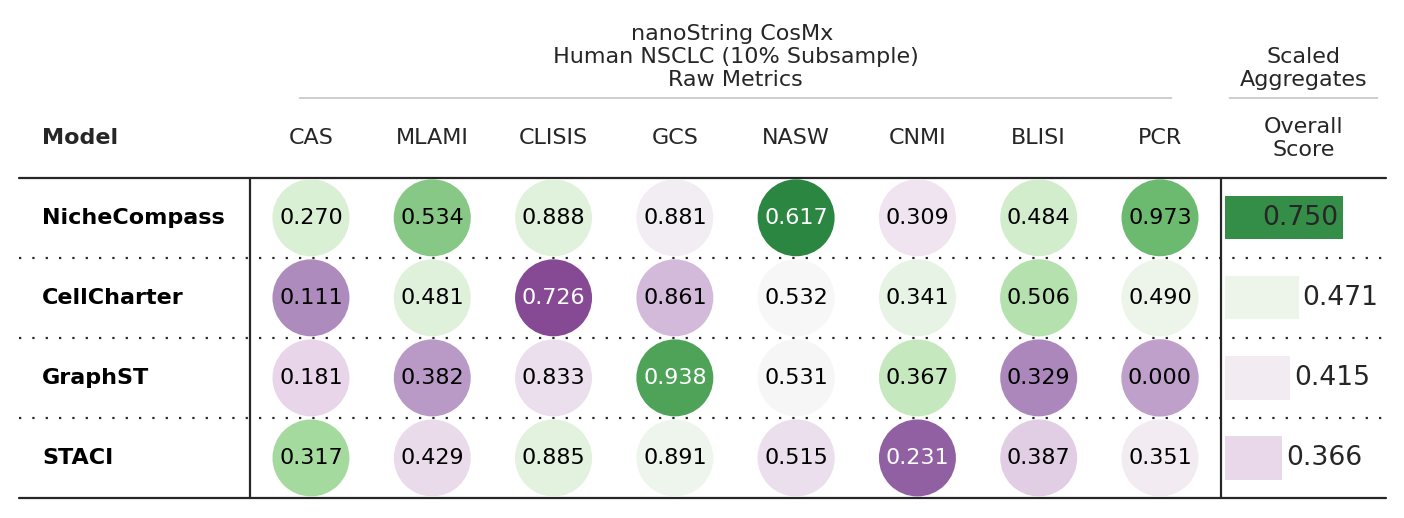

In [18]:
### Fig. 3e: 10 pct subsample comparison ###
datasets = ["nanostring_cosmx_human_nsclc_subsample_10pct"]
models = ["nichecompass_gatv2conv_fov",
          "staci",
          "graphst_paste",
          "cellcharter"]

summary_df = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.DataFrame()
    for model in models:
        try:
            benchmark_df = pd.read_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv")
            #adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
            #training_durations = []
            #for run_number in [1, 2, 3, 4, 5, 6, 7, 8]:
            #    training_durations.append(adata.uns[f"{model.split('_')[0]}_model_training_duration_run{run_number}"])
            #benchmark_df["run_time"] = training_durations
            #benchmark_df = benchmark_df[["dataset", "run_number", "run_time", "gcs", "mlami", "cas", "clisis", "nasw", "cnmi", "cari", "casw", "clisi"]]
            #benchmark_df.to_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv", index=False)
            benchmark_df["model"] = model
            dataset_df = pd.concat([dataset_df, benchmark_df], ignore_index=True)
        except FileNotFoundError:
            print(f"Did not find file {benchmarking_folder_path}/{dataset}_{model}_metrics.csv. Continuing...")
            missing_run_data = {
                "dataset": [dataset] * 8,
                "model": [model] * 8,
                "run_number": [1, 2, 3, 4, 5, 6, 7, 8],
                "run_time": [np.nan] * 8
            }
            missing_run_df = pd.DataFrame(missing_run_data)
            dataset_df = pd.concat([dataset_df, missing_run_df], ignore_index=True)
            
    # Apply min-max scaling to metric columns
    for i in range(len(metric_cols_sample_integration)):
        min_val = dataset_df[metric_cols_sample_integration[i]].min()
        max_val = dataset_df[metric_cols_sample_integration[i]].max()
        dataset_df[metric_cols_sample_integration[i] + "_scaled"] = ((
            dataset_df[metric_cols_sample_integration[i]] - min_val) / (max_val - min_val))

    summary_df = pd.concat([summary_df, dataset_df], ignore_index=True)
    continue
    
summary_df['pcr'] = summary_df['pcr'].fillna(0)
summary_df['pcr_scaled'] = summary_df['pcr_scaled'].fillna(0)
            
cat_0_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_sample_integration[0:2]]
cat_1_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_sample_integration[2:4]]
cat_2_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_sample_integration[4:6]]
cat_3_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_sample_integration[6:8]]
    
summary_df[category_cols_sample_integration[0]] = np.average(summary_df[cat_0_scaled_metric_cols],
                                                        weights=metric_col_weights_sample_integration[0:2],
                                                        axis=1)
summary_df[category_cols_sample_integration[1]] = np.average(summary_df[cat_1_scaled_metric_cols],
                                                        weights=metric_col_weights_sample_integration[2:4],
                                                        axis=1)
summary_df[category_cols_sample_integration[2]] = np.average(summary_df[cat_2_scaled_metric_cols],
                                                        weights=metric_col_weights_sample_integration[4:6],
                                                        axis=1)
summary_df[category_cols_sample_integration[3]] = np.average(summary_df[cat_3_scaled_metric_cols],
                                                        weights=metric_col_weights_sample_integration[6:8],
                                                        axis=1)
summary_df["Overall Score"] = np.average(summary_df[category_cols_sample_integration[:4]],
                                         weights=category_col_weights_sample_integration[:4],
                                         axis=1)
 
# Reformat for plot
summary_df.replace({"nichecompass_gatv2conv_fov": "NicheCompass",
                    "staci": "STACI",
                    "graphst_paste": "GraphST",
                    "cellcharter": "CellCharter"}, inplace=True)

summary_df = summary_df[(summary_df["run_number"] == 2) & (summary_df["model"] != "STACI") |
                        (summary_df["run_number"] == 1) & (summary_df["model"] == "STACI")]

# Plot over all loss weights combinations
# Prepare metrics table plot
group_cols = ["dataset", "model"]
aggregate_df = summary_df.groupby(group_cols).mean("Overall Score").sort_values("Overall Score", ascending=False)[
    metric_cols_sample_integration + ["Overall Score"]].reset_index()

unrolled_df = pd.melt(aggregate_df, 
   id_vars=group_cols,
   value_vars=metric_cols_sample_integration + ["Overall Score"], # metric_cols_sample_integration, category_cols_sample_integration
   var_name="score_type", 
   value_name="score")

# Create spatial indicator column
def is_spatially_aware_model(row):
    if row["model"] in ["NicheCompass", "NicheCompass Light", "GraphST", "GraphST (No Prior Alignment)", "CellCharter"]:
        return True
    return False
unrolled_df["spatially_aware"] = unrolled_df.apply(lambda row: is_spatially_aware_model(row), axis=1)
unrolled_df = unrolled_df[["dataset", "spatially_aware", "model", "score_type", "score"]]

# Order datasets
unrolled_df["dataset"] = pd.Categorical(unrolled_df["dataset"], categories=datasets, ordered=True)
unrolled_df = unrolled_df.sort_values(by="dataset")

#print(summary_df["model"].value_counts())
#print(summary_df[summary_df.isna().any(axis=1)])

summary_df["model"] = summary_df["model"].replace("NicheCompass GCN", "NicheCompass Light")
summary_df["model"] = summary_df["model"].replace("NicheCompass GATv2", "NicheCompass")

summary_df["dataset"] = summary_df["dataset"].replace(
    {"nanostring_cosmx_human_nsclc_subsample_10pct": "nanoString CosMx Human NSCLC"})

# Plot table
plot_simple_metrics_table(
    df=unrolled_df,
    model_col="model",
    model_col_width=2.1,
    group_col="dataset",
    metric_cols=metric_cols_sample_integration, # metric_cols_sample_integration, category_cols_sample_integration
    metric_col_weights=metric_col_weights_sample_integration, # metric_col_weights_sample_integration, category_col_weights_sample_integration
    metric_col_titles=[col.replace(" ", "\n") for col in metric_col_titles_sample_integration], # category_col_titles_sample_integration
    metric_col_width=1.1, # 0.8,
    plot_width=11, # 32,
    plot_height=4,
    show=True,
    save_dir=benchmarking_folder_path,
    save_name=f"benchmarking_metrics_nanostring_cosmx_human_nsclc_subsample_10pct_run2.svg")

In [ ]:
### Supplementary fig. 14: 10 pct subsample comparison NC vs STACI vs GraphST variations vs CellCharter ###
datasets = ["nanostring_cosmx_human_nsclc_subsample_10pct"]
models = ["nichecompass_gatv2conv_fov",
          "nichecompass_gatv2conv",
          "nichecompass_gcnconv_fov",
          "nichecompass_gcnconv",
          "staci",
          "graphst_paste",
          "graphst",
          "cellcharter"]

summary_df = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.DataFrame()
    for model in models:
        try:
            benchmark_df = pd.read_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv")
            #adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
            #training_durations = []
            #for run_number in [1, 2, 3, 4, 5, 6, 7, 8]:
            #    training_durations.append(adata.uns[f"{model.split('_')[0]}_model_training_duration_run{run_number}"])
            #benchmark_df["run_time"] = training_durations
            #benchmark_df = benchmark_df[["dataset", "run_number", "run_time", "gcs", "mlami", "cas", "clisis", "nasw", "cnmi", "cari", "casw", "clisi"]]
            #benchmark_df.to_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv", index=False)
            benchmark_df["model"] = model
            dataset_df = pd.concat([dataset_df, benchmark_df], ignore_index=True)
        except FileNotFoundError:
            print(f"Did not find file {benchmarking_folder_path}/{dataset}_{model}_metrics.csv. Continuing...")
            missing_run_data = {
                "dataset": [dataset] * 8,
                "model": [model] * 8,
                "run_number": [1, 2, 3, 4, 5, 6, 7, 8],
                "run_time": [np.nan] * 8
            }
            missing_run_df = pd.DataFrame(missing_run_data)
            dataset_df = pd.concat([dataset_df, missing_run_df], ignore_index=True)
            
    # Apply min-max scaling to metric columns
    for i in range(len(metric_cols_sample_integration)):
        min_val = dataset_df[metric_cols_sample_integration[i]].min()
        max_val = dataset_df[metric_cols_sample_integration[i]].max()
        dataset_df[metric_cols_sample_integration[i] + "_scaled"] = ((
            dataset_df[metric_cols_sample_integration[i]] - min_val) / (max_val - min_val))

    summary_df = pd.concat([summary_df, dataset_df], ignore_index=True)
    continue
    
summary_df['pcr'] = summary_df['pcr'].fillna(0)
summary_df['pcr_scaled'] = summary_df['pcr_scaled'].fillna(0)
            
cat_0_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_sample_integration[0:2]]
cat_1_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_sample_integration[2:4]]
cat_2_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_sample_integration[4:6]]
cat_3_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_sample_integration[6:8]]
    
summary_df[category_cols_sample_integration[0]] = np.average(summary_df[cat_0_scaled_metric_cols],
                                                        weights=metric_col_weights_sample_integration[0:2],
                                                        axis=1)
summary_df[category_cols_sample_integration[1]] = np.average(summary_df[cat_1_scaled_metric_cols],
                                                        weights=metric_col_weights_sample_integration[2:4],
                                                        axis=1)
summary_df[category_cols_sample_integration[2]] = np.average(summary_df[cat_2_scaled_metric_cols],
                                                        weights=metric_col_weights_sample_integration[4:6],
                                                        axis=1)
summary_df[category_cols_sample_integration[3]] = np.average(summary_df[cat_3_scaled_metric_cols],
                                                        weights=metric_col_weights_sample_integration[6:8],
                                                        axis=1)
summary_df["Overall Score"] = np.average(summary_df[category_cols_sample_integration[:4]],
                                         weights=category_col_weights_sample_integration[:4],
                                         axis=1)
 
# Reformat for plot
summary_df.replace({"nichecompass_gatv2conv_fov": "NicheCompass",
                    "nichecompass_gatv2conv": "NicheCompass (No FoV Embedding)",
                    "nichecompass_gcnconv_fov": "NicheCompass Light",
                    "nichecompass_gcnconv": "NicheCompass Light (No FoV Embedding)",
                    "staci": "STACI",
                    "graphst_paste": "GraphST",
                    "graphst": "GraphST (No Prior Alignment)",
                    "cellcharter": "CellCharter"}, inplace=True)

summary_df = summary_df[(summary_df["run_number"] == 2) & (summary_df["model"] != "STACI") |
                        (summary_df["run_number"] == 1) & (summary_df["model"] == "STACI")]

summary_df['pcr'] = summary_df['pcr'].fillna(0)

# Plot over all loss weights combinations
# Prepare metrics table plot
group_cols = ["dataset", "model"]
aggregate_df = summary_df.groupby(group_cols).mean("Overall Score").sort_values("Overall Score", ascending=False)[
    metric_cols_sample_integration + ["Overall Score"]].reset_index()

unrolled_df = pd.melt(aggregate_df, 
   id_vars=group_cols,
   value_vars=metric_cols_sample_integration + ["Overall Score"], # metric_cols_sample_integration, category_cols_sample_integration
   var_name="score_type", 
   value_name="score")

# Create spatial indicator column
def is_spatially_aware_model(row):
    if row["model"] in ["NicheCompass",
                        "NicheCompass (No FoV Embedding)",
                        "NicheCompass Light",
                        "NicheCompass Light (No FoV Embedding)",
                        "GraphST",
                        "GraphST (No Prior Alignment)",
                        "CellCharter"]:
        return True
    return False
unrolled_df["spatially_aware"] = unrolled_df.apply(lambda row: is_spatially_aware_model(row), axis=1)
unrolled_df = unrolled_df[["dataset", "spatially_aware", "model", "score_type", "score"]]

# Order datasets
unrolled_df["dataset"] = pd.Categorical(unrolled_df["dataset"], categories=datasets, ordered=True)
unrolled_df = unrolled_df.sort_values(by="dataset")

#print(summary_df["model"].value_counts())
#print(summary_df[summary_df.isna().any(axis=1)])

summary_df["model"] = summary_df["model"].replace("NicheCompass GCN", "NicheCompass Light")
summary_df["model"] = summary_df["model"].replace("NicheCompass GATv2", "NicheCompass")

summary_df["dataset"] = summary_df["dataset"].replace(
    {"nanostring_cosmx_human_nsclc_subsample_10pct": "nanoString CosMx Human NSCLC"})

# Plot table
plot_simple_metrics_table(
    df=unrolled_df,
    model_col="model",
    model_col_width=5.5,
    group_col="dataset",
    metric_cols=metric_cols_sample_integration, # metric_cols_sample_integration, category_cols_sample_integration
    metric_col_weights=metric_col_weights_sample_integration, # metric_col_weights_sample_integration, category_col_weights_sample_integration
    metric_col_titles=[col.replace(" ", "\n") for col in metric_col_titles_sample_integration], # category_col_titles_sample_integration
    metric_col_width=1.1, # 0.8,
    plot_width=14, # 32,
    plot_height=8,
    show=True,
    save_dir=benchmarking_folder_path,
    save_name=f"benchmarking_metrics_nanostring_cosmx_human_nsclc_subsample_10pct_run2_supplement.svg")

In [25]:
datasets = ["nanostring_cosmx_human_nsclc",
            "nanostring_cosmx_human_nsclc_subsample_50pct",
            "nanostring_cosmx_human_nsclc_subsample_25pct",
            "nanostring_cosmx_human_nsclc_subsample_10pct",
            "nanostring_cosmx_human_nsclc_subsample_5pct",
            "nanostring_cosmx_human_nsclc_subsample_1pct"]
models = ["nichecompass_gatv2conv",
          "nichecompass_gcnconv",
          "staci",
          "graphst_paste",
          "graphst",
          "cellcharter"]

summary_df = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.DataFrame()
    for model in models:
        try:
            benchmark_df = pd.read_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv")
            #adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
            #training_durations = []
            #for run_number in [1, 2, 3, 4, 5, 6, 7, 8]:
            #    training_durations.append(adata.uns[f"{model.split('_')[0]}_model_training_duration_run{run_number}"])
            #benchmark_df["run_time"] = training_durations
            #benchmark_df = benchmark_df[["dataset", "run_number", "run_time", "gcs", "mlami", "cas", "clisis", "nasw", "cnmi", "cari", "casw", "clisi"]]
            #benchmark_df.to_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv", index=False)
            benchmark_df["model"] = model
            dataset_df = pd.concat([dataset_df, benchmark_df], ignore_index=True)
        except FileNotFoundError:
            print(f"Did not find file {benchmarking_folder_path}/{dataset}_{model}_metrics.csv. Continuing...")
            missing_run_data = {
                "dataset": [dataset] * 8,
                "model": [model] * 8,
                "run_number": [1, 2, 3, 4, 5, 6, 7, 8],
                "run_time": [np.nan] * 8
            }
            missing_run_df = pd.DataFrame(missing_run_data)
            dataset_df = dataset_df = pd.concat([dataset_df, missing_run_df], ignore_index=True)
            
    # Apply min-max scaling to metric columns
    for i in range(len(metric_cols_sample_integration)):
        min_val = dataset_df[metric_cols_sample_integration[i]].min()
        max_val = dataset_df[metric_cols_sample_integration[i]].max()
        dataset_df[metric_cols_sample_integration[i] + "_scaled"] = ((
            dataset_df[metric_cols_sample_integration[i]] - min_val) / (max_val - min_val))

    summary_df = pd.concat([summary_df, dataset_df], ignore_index=True)
    continue

summary_df['pcr'] = summary_df['pcr'].fillna(0)
summary_df['pcr_scaled'] = summary_df['pcr_scaled'].fillna(0)
    
cat_0_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_sample_integration[0:2]]
cat_1_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_sample_integration[2:4]]
cat_2_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_sample_integration[4:6]]
cat_3_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_sample_integration[6:8]]
    
summary_df[category_cols_sample_integration[0]] = np.average(summary_df[cat_0_scaled_metric_cols],
                                                        weights=metric_col_weights_sample_integration[0:2],
                                                        axis=1)
summary_df[category_cols_sample_integration[1]] = np.average(summary_df[cat_1_scaled_metric_cols],
                                                        weights=metric_col_weights_sample_integration[2:4],
                                                        axis=1)
summary_df[category_cols_sample_integration[2]] = np.average(summary_df[cat_2_scaled_metric_cols],
                                                        weights=metric_col_weights_sample_integration[4:6],
                                                        axis=1)
summary_df[category_cols_sample_integration[3]] = np.average(summary_df[cat_3_scaled_metric_cols],
                                                        weights=metric_col_weights_sample_integration[6:8],
                                                        axis=1)
summary_df["Overall Score"] = np.average(summary_df[category_cols_sample_integration[:4]],
                                         weights=category_col_weights_sample_integration[:4],
                                         axis=1)
 
# Reformat for plot
summary_df.replace({"nichecompass_gatv2conv": "NicheCompass",
                    "nichecompass_gcnconv": "NicheCompass Light",
                    "staci": "STACI",
                    "graphst_paste": "GraphST",
                    "graphst": "GraphST (No Prior Alignment)",
                    "cellcharter": "CellCharter"}, inplace=True)

# Plot over all loss weights combinations
# Prepare metrics table plot
group_cols = ["dataset", "model"]
aggregate_df = summary_df.groupby(group_cols).mean("Overall Score").sort_values("Overall Score", ascending=False)[
    metric_cols_sample_integration + ["Overall Score"]].reset_index()

unrolled_df = pd.melt(aggregate_df, 
   id_vars=group_cols,
   value_vars=metric_cols_sample_integration + ["Overall Score"], # metric_cols_sample_integration, category_cols_sample_integration
   var_name="score_type", 
   value_name="score")

# Create spatial indicator column
def is_spatially_aware_model(row):
    if row["model"] in ["NicheCompass", "NicheCompass Light", "GraphST", "GraphST (No Prior Alignment)", "CellCharter"]:
        return True
    return False

unrolled_df["spatially_aware"] = unrolled_df.apply(lambda row: is_spatially_aware_model(row), axis=1)
unrolled_df = unrolled_df[["dataset", "spatially_aware", "model", "score_type", "score"]]

# Order datasets
unrolled_df["dataset"] = pd.Categorical(unrolled_df["dataset"], categories=datasets, ordered=True)
unrolled_df = unrolled_df.sort_values(by="dataset")

#print(summary_df["model"].value_counts())
#print(summary_df[summary_df.isna().any(axis=1)])

summary_df["model"] = summary_df["model"].replace("NicheCompass GCN", "NicheCompass Light")
summary_df["model"] = summary_df["model"].replace("NicheCompass GATv2", "NicheCompass")

Did not find file ../../artifacts/sample_integration_method_benchmarking/nanostring_cosmx_human_nsclc_staci_metrics.csv. Continuing...
Did not find file ../../artifacts/sample_integration_method_benchmarking/nanostring_cosmx_human_nsclc_graphst_paste_metrics.csv. Continuing...
Did not find file ../../artifacts/sample_integration_method_benchmarking/nanostring_cosmx_human_nsclc_graphst_metrics.csv. Continuing...
Did not find file ../../artifacts/sample_integration_method_benchmarking/nanostring_cosmx_human_nsclc_subsample_50pct_staci_metrics.csv. Continuing...
Did not find file ../../artifacts/sample_integration_method_benchmarking/nanostring_cosmx_human_nsclc_subsample_50pct_graphst_paste_metrics.csv. Continuing...
Did not find file ../../artifacts/sample_integration_method_benchmarking/nanostring_cosmx_human_nsclc_subsample_50pct_graphst_metrics.csv. Continuing...
Did not find file ../../artifacts/sample_integration_method_benchmarking/nanostring_cosmx_human_nsclc_subsample_25pct_stac

/tmp/ipykernel_2341122/1785852907.py:45: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:
/tmp/ipykernel_2341122/1785852907.py:47: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles, labels = legend.legendHandles, [text.get_text() for text in legend.get_texts()]


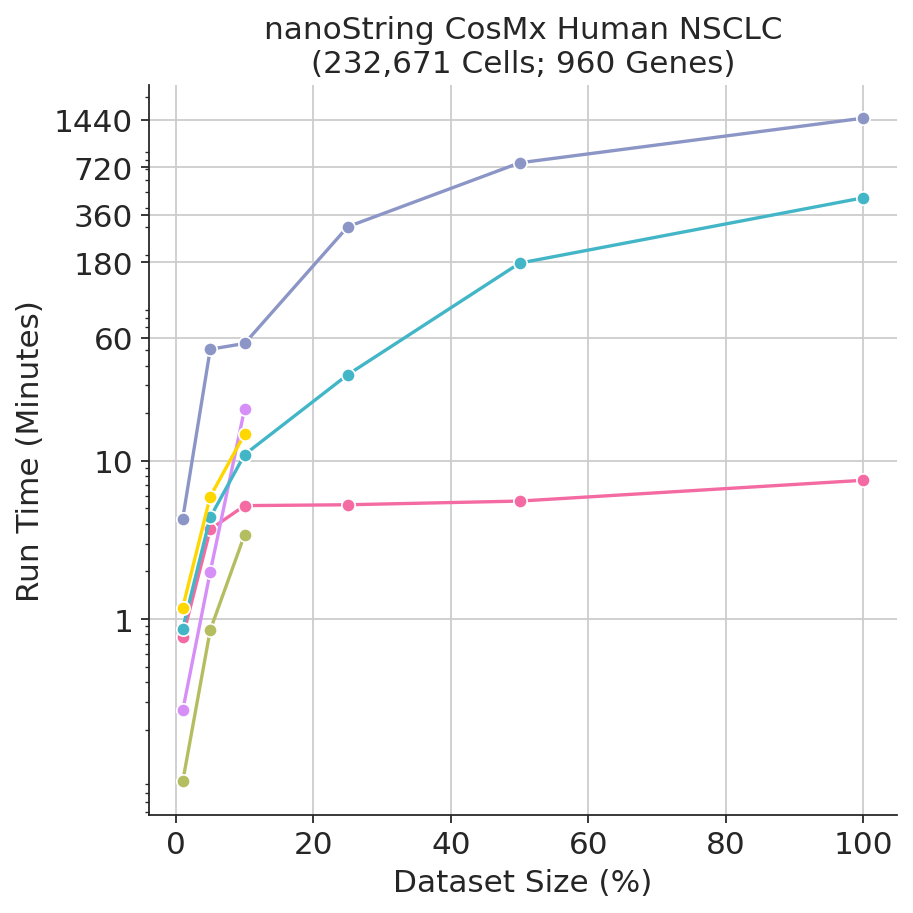

In [31]:
### Supplementary figure: scalability ###
model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "STACI": "#FFD700",
                 "GraphST": "#D78FF8",
                 "GraphST (No Prior Alignment)": "#b5bd61",
                 "CellCharter": "#F46AA2"
                 }

run_time_mean_df = summary_df.groupby(["dataset", "model"])[["run_time"]].mean().reset_index()
run_time_mean_df["run_time"] = run_time_mean_df["run_time"] / 60

def create_dataset_share_col(row):
    if row["dataset"] == "nanostring_cosmx_human_nsclc":
        return 100
    elif row["dataset"] == "nanostring_cosmx_human_nsclc_subsample_50pct":    
        return 50
    elif row["dataset"] == "nanostring_cosmx_human_nsclc_subsample_25pct":    
        return 25
    elif row["dataset"] == "nanostring_cosmx_human_nsclc_subsample_10pct":    
        return 10
    elif row["dataset"] == "nanostring_cosmx_human_nsclc_subsample_5pct":    
        return 5
    elif row["dataset"] == "nanostring_cosmx_human_nsclc_subsample_1pct":    
        return 1
    
run_time_mean_df["dataset_share"] = run_time_mean_df.apply(lambda row: create_dataset_share_col(row), axis=1)

with sns.axes_style("ticks"):
    ax = sns.lineplot(data=run_time_mean_df,
                      x="dataset_share",
                      y="run_time",
                      hue="model",
                      marker='o',
                      palette=model_palette)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title("nanoString CosMx Human NSCLC\n(232,671 Cells; 960 Genes)")
    plt.ylabel("Run Time (Minutes)")
    plt.xlabel("Dataset Size (%)")
    custom_y_ticks = [1, 10, 60, 180, 360, 720, 1440]  # Adjust the tick positions as needed
    plt.yscale("log")
    plt.yticks(custom_y_ticks, custom_y_ticks)
    legend = plt.gca().get_legend()
    for handle in legend.legendHandles:
        handle.set_linewidth(4.0)  # Adjust the size as needed
    handles, labels = legend.legendHandles, [text.get_text() for text in legend.get_texts()]
    order = [1, 2, 0]
    ordered_handles = [handles[i] for i in order]
    ordered_labels = [labels[i] for i in order]
    plt.legend(ordered_handles, ordered_labels)
    ax = plt.gca()
    ax.legend().set_visible(False)
    plt.grid(True)
    plt.savefig(benchmarking_folder_path + "/benchmarking_runtimes_nanostring_cosmx_human_nsclc.svg")
    plt.show()

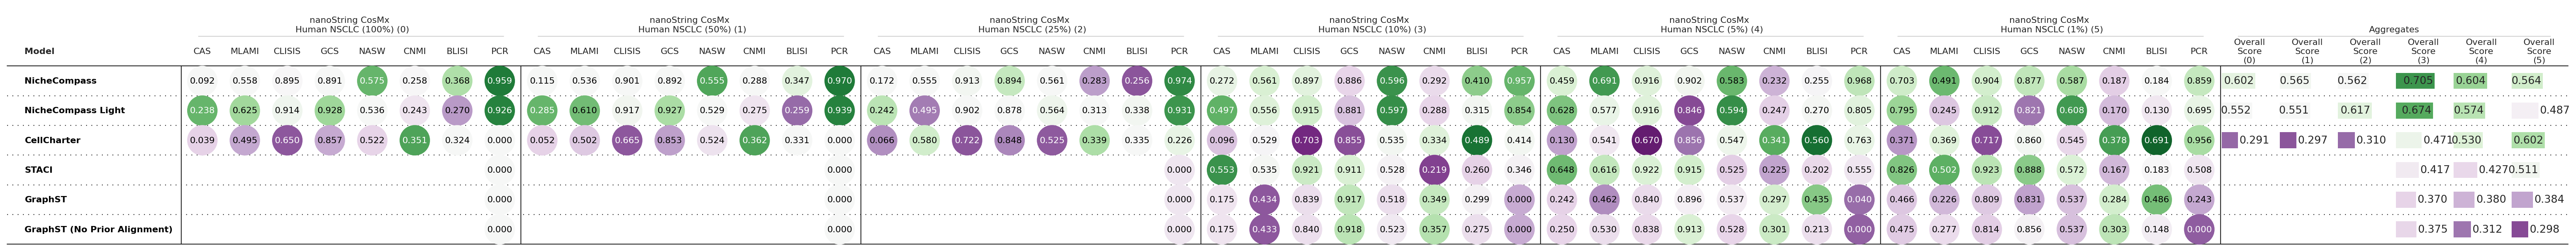

In [32]:
### Supplementary fig. 16b: sample integration metric averages ###
# Define the custom sort order
custom_order = ["NicheCompass", "NicheCompass Light", "CellCharter", "STACI", "GraphST", "GraphST (No Prior Alignment)"]

# Convert the 'category' column to a categorical data type with the custom order
unrolled_df['model'] = pd.Categorical(unrolled_df['model'], categories=custom_order, ordered=True)

# Sort the DataFrame based on the 'category' column
unrolled_df = unrolled_df.sort_values(['dataset', 'model'])

plot_metrics_table(
    df=unrolled_df,
    model_col="model",
    model_col_width=4.5,
    group_col="dataset",
    metric_cols=metric_cols_sample_integration, # metric_cols_sample_integration, category_cols_sample_integration
    metric_col_weights=metric_col_weights_sample_integration, # metric_col_weights_sample_integration, category_col_weights_sample_integration
    metric_col_titles=[col.replace(" ", "\n") for col in metric_col_titles_sample_integration], # category_col_titles_sample_integration
    metric_col_width=1.1, # 0.8,
    plot_width=52, # 32,
    plot_height=5,
    show=True,
    save_dir=benchmarking_folder_path,
    save_name=f"benchmarking_metrics_nanostring_cosmx_human_nsclc.svg")

#### 2.1.2 seqFISH Mouse Organogenesis

In [ ]:
datasets = ["seqfish_mouse_organogenesis",
            "seqfish_mouse_organogenesis_subsample_50pct",
            "seqfish_mouse_organogenesis_subsample_25pct",
            "seqfish_mouse_organogenesis_subsample_10pct",
            "seqfish_mouse_organogenesis_subsample_5pct",
            "seqfish_mouse_organogenesis_subsample_1pct"]
models = ["nichecompass_gatv2conv",
          "nichecompass_gcnconv",
          "staci",
          "graphst_paste",
          "graphst",
          "cellcharter"]

summary_df = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.DataFrame()
    for model in models:
        try:
            benchmark_df = pd.read_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv")
            #adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
            #training_durations = []
            #for run_number in [1, 2, 3, 4, 5, 6, 7, 8]:
            #    training_durations.append(adata.uns[f"{model.split('_')[0]}_model_training_duration_run{run_number}"])
            #benchmark_df["run_time"] = training_durations
            #benchmark_df = benchmark_df[["dataset", "run_number", "run_time", "gcs", "mlami", "cas", "clisis", "nasw", "cnmi", "cari", "casw", "clisi"]]
            #benchmark_df.to_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv", index=False)
            benchmark_df["model"] = model
            dataset_df = pd.concat([dataset_df, benchmark_df], ignore_index=True)
        except FileNotFoundError:
            print(f"Did not find file {benchmarking_folder_path}/{dataset}_{model}_metrics.csv. Continuing...")
            missing_run_data = {
                "dataset": [dataset] * 8,
                "model": [model] * 8,
                "run_number": [1, 2, 3, 4, 5, 6, 7, 8],
                "run_time": [np.nan] * 8
            }
            missing_run_df = pd.DataFrame(missing_run_data)
            dataset_df = pd.concat([dataset_df, missing_run_df], ignore_index=True)
            
    # Apply min-max scaling to metric columns
    for i in range(len(metric_cols_sample_integration)):
        min_val = dataset_df[metric_cols_sample_integration[i]].min()
        max_val = dataset_df[metric_cols_sample_integration[i]].max()
        dataset_df[metric_cols_sample_integration[i] + "_scaled"] = ((
            dataset_df[metric_cols_sample_integration[i]] - min_val) / (max_val - min_val))

    summary_df = pd.concat([summary_df, dataset_df], ignore_index=True)
    continue
    
summary_df['pcr'] = summary_df['pcr'].fillna(0)
summary_df['pcr_scaled'] = summary_df['pcr_scaled'].fillna(0)
            
cat_0_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_sample_integration[0:2]]
cat_1_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_sample_integration[2:4]]
cat_2_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_sample_integration[4:6]]
cat_3_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_sample_integration[6:8]]
    
summary_df[category_cols_sample_integration[0]] = np.average(summary_df[cat_0_scaled_metric_cols],
                                                        weights=metric_col_weights_sample_integration[0:2],
                                                        axis=1)
summary_df[category_cols_sample_integration[1]] = np.average(summary_df[cat_1_scaled_metric_cols],
                                                        weights=metric_col_weights_sample_integration[2:4],
                                                        axis=1)
summary_df[category_cols_sample_integration[2]] = np.average(summary_df[cat_2_scaled_metric_cols],
                                                        weights=metric_col_weights_sample_integration[4:6],
                                                        axis=1)
summary_df[category_cols_sample_integration[3]] = np.average(summary_df[cat_3_scaled_metric_cols],
                                                        weights=metric_col_weights_sample_integration[6:8],
                                                        axis=1)
summary_df["Overall Score"] = np.average(summary_df[category_cols_sample_integration[:4]],
                                         weights=category_col_weights_sample_integration[:4],
                                         axis=1)
 
# Reformat for plot
summary_df.replace({"nichecompass_gatv2conv": "NicheCompass",
                    "nichecompass_gcnconv": "NicheCompass Light",
                    "staci": "STACI",
                    "graphst_paste": "GraphST",
                    "graphst": "GraphST (No Prior Alignment)",
                    "cellcharter": "CellCharter"}, inplace=True)

# Plot over all loss weights combinations
# Prepare metrics table plot
group_cols = ["dataset", "model"]
aggregate_df = summary_df.groupby(group_cols).mean("Overall Score").sort_values("Overall Score", ascending=False)[
    metric_cols_sample_integration + ["Overall Score"]].reset_index()

unrolled_df = pd.melt(aggregate_df, 
   id_vars=group_cols,
   value_vars=metric_cols_sample_integration + ["Overall Score"], # metric_cols_sample_integration, category_cols_sample_integration
   var_name="score_type", 
   value_name="score")

# Create spatial indicator column
def is_spatially_aware_model(row):
    if row["model"] in ["NicheCompass", "NicheCompass Light", "GraphST", "GraphST (No Prior Alignment)"]:
        return True
    return False
unrolled_df["spatially_aware"] = unrolled_df.apply(lambda row: is_spatially_aware_model(row), axis=1)
unrolled_df = unrolled_df[["dataset", "spatially_aware", "model", "score_type", "score"]]

# Order datasets
unrolled_df["dataset"] = pd.Categorical(unrolled_df["dataset"], categories=datasets, ordered=True)
unrolled_df = unrolled_df.sort_values(by="dataset")

#print(summary_df["model"].value_counts())
#print(summary_df[summary_df.isna().any(axis=1)])

summary_df["model"] = summary_df["model"].replace("NicheCompass GCN", "NicheCompass Light")
summary_df["model"] = summary_df["model"].replace("NicheCompass GATv2", "NicheCompass")

In [ ]:
### Supplementary fig. 17: sample integration runtimes ###
model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "STACI": "#FFD700",
                 "GraphST": "#D78FF8",
                 "GraphST (No Prior Alignment)": "#b5bd61",
                 "CellCharter": "#F46AA2"
                 }

run_time_mean_df = summary_df.groupby(["dataset", "model"])[["run_time"]].mean().reset_index()
run_time_mean_df["run_time"] = run_time_mean_df["run_time"] / 60

def create_dataset_share_col(row):
    if row["dataset"] == "seqfish_mouse_organogenesis":
        return 100
    elif row["dataset"] == "seqfish_mouse_organogenesis_subsample_50pct":    
        return 50
    elif row["dataset"] == "seqfish_mouse_organogenesis_subsample_25pct":    
        return 25
    elif row["dataset"] == "seqfish_mouse_organogenesis_subsample_10pct":    
        return 10
    elif row["dataset"] == "seqfish_mouse_organogenesis_subsample_5pct":    
        return 5
    elif row["dataset"] == "seqfish_mouse_organogenesis_subsample_1pct":    
        return 1
    
run_time_mean_df["dataset_share"] = run_time_mean_df.apply(lambda row: create_dataset_share_col(row), axis=1)

with sns.axes_style("ticks"):
    ax = sns.lineplot(data=run_time_mean_df,
                      x="dataset_share",
                      y="run_time",
                      hue="model",
                      marker='o',
                      palette=model_palette)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title("seqFISH Mouse Organogenesis\n(57,536 Cells; 351 Genes)")
    plt.ylabel("Run Time (Minutes)")
    plt.xlabel("Dataset Size (%)")
    custom_y_ticks = [1, 10, 60, 180, 360, 720, 1440]  # Adjust the tick positions as needed
    plt.yscale("log")
    plt.yticks(custom_y_ticks, custom_y_ticks)
    legend = plt.gca().get_legend()
    for handle in legend.legendHandles:
        handle.set_linewidth(4.0)  # Adjust the size as needed
    handles, labels = legend.legendHandles, [text.get_text() for text in legend.get_texts()]
    order = [1, 2, 0]
    ordered_handles = [handles[i] for i in order]
    ordered_labels = [labels[i] for i in order]
    plt.legend(ordered_handles, ordered_labels)
    ax = plt.gca()
    ax.legend().set_visible(False)
    plt.grid(True)
    plt.savefig(benchmarking_folder_path + "/benchmarking_runtimes_seqfish_mouse_organogenesis.svg")
    plt.show()

In [ ]:
### Supplementary fig. 16b: sample integration metric averages ###
plot_metrics_table(
    df=unrolled_df,
    model_col="model",
    model_col_width=4.5,
    group_col="dataset",
    metric_cols=metric_cols_sample_integration, # metric_cols_sample_integration, category_cols_sample_integration
    metric_col_weights=metric_col_weights_sample_integration, # metric_col_weights_sample_integration, category_col_weights_sample_integration
    metric_col_titles=[col.replace(" ", "\n") for col in metric_col_titles_sample_integration], # category_col_titles_sample_integration
    metric_col_width=1.1, # 0.8,
    plot_width=52, # 32,
    plot_height=5,
    show=True,
    save_dir=benchmarking_folder_path,
    save_name=f"benchmarking_metrics_seqfish_mouse_organogenesis.svg")

#### 2.1.3 seqFISH Mouse Organogenesis Imputed

In [14]:
datasets = ["seqfish_mouse_organogenesis_imputed",
            "seqfish_mouse_organogenesis_imputed_subsample_50pct",
            "seqfish_mouse_organogenesis_imputed_subsample_25pct",
            "seqfish_mouse_organogenesis_imputed_subsample_10pct",
            "seqfish_mouse_organogenesis_imputed_subsample_5pct",
            "seqfish_mouse_organogenesis_imputed_subsample_1pct"]
models = ["nichecompass_gatv2conv",
          "nichecompass_gcnconv",
          "staci",
          "graphst_paste",
          "graphst",
          "cellcharter"]

summary_df = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.DataFrame()
    for model in models:
        try:
            benchmark_df = pd.read_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv")
            #adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
            #training_durations = []
            #for run_number in [1, 2, 3, 4, 5, 6, 7, 8]:
            #    training_durations.append(adata.uns[f"{model.split('_')[0]}_model_training_duration_run{run_number}"])
            #benchmark_df["run_time"] = training_durations
            #benchmark_df = benchmark_df[["dataset", "run_number", "run_time", "gcs", "mlami", "cas", "clisis", "nasw", "cnmi", "cari", "casw", "clisi"]]
            #benchmark_df.to_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv", index=False)
            benchmark_df["model"] = model
            dataset_df = pd.concat([dataset_df, benchmark_df], ignore_index=True)
        except FileNotFoundError:
            print(f"Did not find file {benchmarking_folder_path}/{dataset}_{model}_metrics.csv. Continuing...")
            missing_run_data = {
                "dataset": [dataset] * 8,
                "model": [model] * 8,
                "run_number": [1, 2, 3, 4, 5, 6, 7, 8],
                "run_time": [np.nan] * 8
            }
            missing_run_df = pd.DataFrame(missing_run_data)
            dataset_df = pd.concat([dataset_df, missing_run_df], ignore_index=True)
            
    # Apply min-max scaling to metric columns
    for i in range(len(metric_cols_sample_integration)):
        min_val = dataset_df[metric_cols_sample_integration[i]].min()
        max_val = dataset_df[metric_cols_sample_integration[i]].max()
        dataset_df[metric_cols_sample_integration[i] + "_scaled"] = ((
            dataset_df[metric_cols_sample_integration[i]] - min_val) / (max_val - min_val))

    summary_df = pd.concat([summary_df, dataset_df], ignore_index=True)
    continue
    
summary_df['pcr'] = summary_df['pcr'].fillna(0)
summary_df['pcr_scaled'] = summary_df['pcr_scaled'].fillna(0)
            
cat_0_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_sample_integration[0:2]]
cat_1_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_sample_integration[2:4]]
cat_2_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_sample_integration[4:6]]
cat_3_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_sample_integration[6:8]]
    
summary_df[category_cols_sample_integration[0]] = np.average(summary_df[cat_0_scaled_metric_cols],
                                                        weights=metric_col_weights_sample_integration[0:2],
                                                        axis=1)
summary_df[category_cols_sample_integration[1]] = np.average(summary_df[cat_1_scaled_metric_cols],
                                                        weights=metric_col_weights_sample_integration[2:4],
                                                        axis=1)
summary_df[category_cols_sample_integration[2]] = np.average(summary_df[cat_2_scaled_metric_cols],
                                                        weights=metric_col_weights_sample_integration[4:6],
                                                        axis=1)
summary_df[category_cols_sample_integration[3]] = np.average(summary_df[cat_3_scaled_metric_cols],
                                                        weights=metric_col_weights_sample_integration[6:8],
                                                        axis=1)
summary_df["Overall Score"] = np.average(summary_df[category_cols_sample_integration[:4]],
                                         weights=category_col_weights_sample_integration[:4],
                                         axis=1)
 
# Reformat for plot
summary_df.replace({"nichecompass_gatv2conv": "NicheCompass",
                    "nichecompass_gcnconv": "NicheCompass Light",
                    "staci": "STACI",
                    "graphst_paste": "GraphST",
                    "graphst": "GraphST (No Prior Alignment)",
                    "cellcharter": "CellCharter"}, inplace=True)

# Plot over all loss weights combinations
# Prepare metrics table plot
group_cols = ["dataset", "model"]
aggregate_df = summary_df.groupby(group_cols).mean("Overall Score").sort_values("Overall Score", ascending=False)[
    metric_cols_sample_integration + ["Overall Score"]].reset_index()

unrolled_df = pd.melt(aggregate_df, 
   id_vars=group_cols,
   value_vars=metric_cols_sample_integration + ["Overall Score"], # metric_cols_sample_integration, category_cols_sample_integration
   var_name="score_type", 
   value_name="score")

# Create spatial indicator column
def is_spatially_aware_model(row):
    if row["model"] in ["NicheCompass", "NicheCompass Light", "GraphST", "CellCharter"]:
        return True
    return False
unrolled_df["spatially_aware"] = unrolled_df.apply(lambda row: is_spatially_aware_model(row), axis=1)
unrolled_df = unrolled_df[["dataset", "spatially_aware", "model", "score_type", "score"]]

# Order datasets
unrolled_df["dataset"] = pd.Categorical(unrolled_df["dataset"], categories=datasets, ordered=True)
unrolled_df = unrolled_df.sort_values(by="dataset")

#print(summary_df["model"].value_counts())
#print(summary_df[summary_df.isna().any(axis=1)])

summary_df["model"] = summary_df["model"].replace("NicheCompass GCN", "NicheCompass Light")
summary_df["model"] = summary_df["model"].replace("NicheCompass GATv2", "NicheCompass")

/tmp/ipykernel_2341122/1906992232.py:45: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:
/tmp/ipykernel_2341122/1906992232.py:47: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles, labels = legend.legendHandles, [text.get_text() for text in legend.get_texts()]


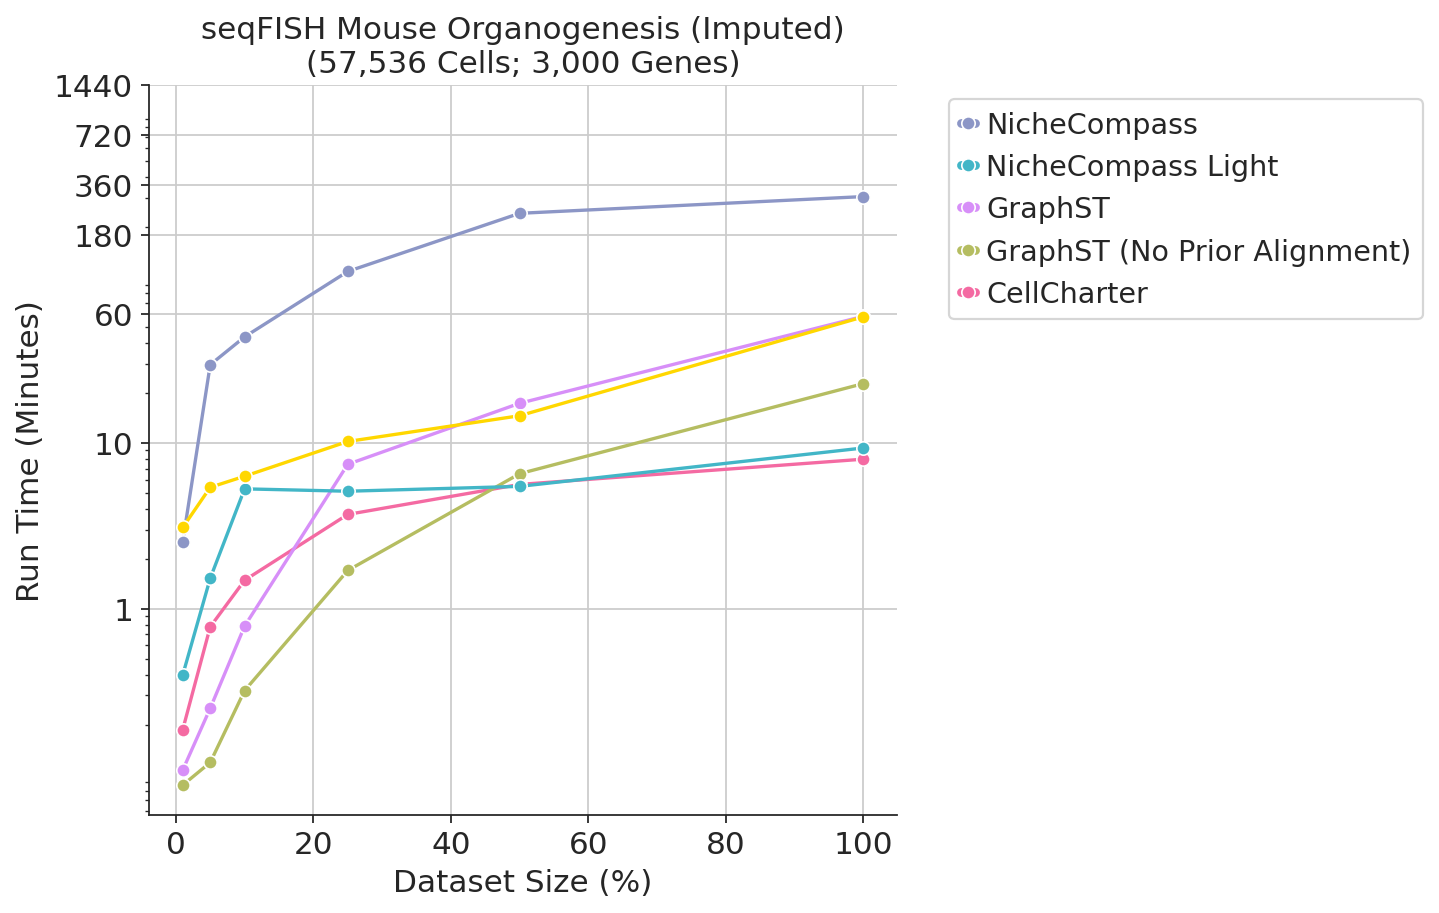

In [17]:
### Supplementary fig. 17: sample integration runtimes ###
model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "STACI":"#FFD700",
                 "GraphST": "#D78FF8",
                 "GraphST (No Prior Alignment)": "#b5bd61",
                 "CellCharter": "#F46AA2"
                 }

run_time_mean_df = summary_df.groupby(["dataset", "model"])[["run_time"]].mean().reset_index()
run_time_mean_df["run_time"] = run_time_mean_df["run_time"] / 60

def create_dataset_share_col(row):
    if row["dataset"] == "seqfish_mouse_organogenesis_imputed":
        return 100
    elif row["dataset"] == "seqfish_mouse_organogenesis_imputed_subsample_50pct":    
        return 50
    elif row["dataset"] == "seqfish_mouse_organogenesis_imputed_subsample_25pct":    
        return 25
    elif row["dataset"] == "seqfish_mouse_organogenesis_imputed_subsample_10pct":    
        return 10
    elif row["dataset"] == "seqfish_mouse_organogenesis_imputed_subsample_5pct":    
        return 5
    elif row["dataset"] == "seqfish_mouse_organogenesis_imputed_subsample_1pct":    
        return 1
    
run_time_mean_df["dataset_share"] = run_time_mean_df.apply(lambda row: create_dataset_share_col(row), axis=1)

with sns.axes_style("ticks"):
    ax = sns.lineplot(data=run_time_mean_df,
                      x="dataset_share",
                      y="run_time",
                      hue="model",
                      marker='o',
                      palette=model_palette)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title("seqFISH Mouse Organogenesis (Imputed)\n(57,536 Cells; 3,000 Genes)")
    plt.ylabel("Run Time (Minutes)")
    plt.xlabel("Dataset Size (%)")
    custom_y_ticks = [1, 10, 60, 180, 360, 720, 1440]  # Adjust the tick positions as needed
    plt.yscale("log")
    plt.yticks(custom_y_ticks, custom_y_ticks)
    legend = plt.gca().get_legend()
    for handle in legend.legendHandles:
        handle.set_linewidth(4.0)  # Adjust the size as needed
    handles, labels = legend.legendHandles, [text.get_text() for text in legend.get_texts()]
    order = [3, 4, 1, 2, 0]
    ordered_handles = [handles[i] for i in order]
    ordered_labels = [labels[i] for i in order]
    lgd = plt.legend(ordered_handles, ordered_labels, bbox_to_anchor=(1.05, 1), loc='upper left')
    ax = plt.gca()
    #ax.legend().set_visible(False)
    plt.grid(True)
    plt.savefig(benchmarking_folder_path + "/benchmarking_runtimes_seqfish_mouse_organogenesis_imputed.svg", bbox_inches="tight", bbox_extra_artists=[lgd])
    plt.show()

In [ ]:
### Supplementary fig. 16b: sample integration metric averages ###
plot_metrics_table(
    df=unrolled_df,
    model_col="model",
    model_col_width=4.5,
    group_col="dataset",
    metric_cols=metric_cols_sample_integration, # metric_cols_sample_integration, category_cols_sample_integration
    metric_col_weights=metric_col_weights_sample_integration, # metric_col_weights_sample_integration, category_col_weights_sample_integration
    metric_col_titles=[col.replace(" ", "\n") for col in metric_col_titles_sample_integration], # category_col_titles_sample_integration
    metric_col_width=1.1, # 0.8,
    plot_width=52, # 32,
    plot_height=5,
    show=True,
    save_dir=benchmarking_folder_path,
    save_name=f"benchmarking_metrics_seqfish_mouse_organogenesis_imputed.svg")

#### 2.1.4 All Datasets

In [33]:
# Define params for plot formatting
fig_width_10_ticks = 8.2
fig_width_9_ticks = 7.8
fig_width_8_ticks = 7.4
fig_width_7_ticks = 7.0
fig_width_6_ticks = 6.6
fig_width_5_ticks = 6.2
fig_width_4_ticks = 5.8
fig_width_2_ticks = 5.1
fig_width_3_ticks = 5.5
fig_height = 5
fontsize = 14
row_fontsize = 16

In [36]:
datasets = ["seqfish_mouse_organogenesis",
            "seqfish_mouse_organogenesis_imputed",
            "nanostring_cosmx_human_nsclc"]
models = ["nichecompass_gatv2conv",
          "nichecompass_gcnconv",
          "staci",
          "graphst_paste",
          "cellcharter"
          #"graphst"
         ]

summary_df = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.DataFrame()
    for model in models:
        try:
            benchmark_df = pd.read_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv")
            #adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
            #training_durations = []
            #for run_number in [1, 2, 3, 4, 5, 6, 7, 8]:
            #    training_durations.append(adata.uns[f"{model.split('_')[0]}_model_training_duration_run{run_number}"])
            #benchmark_df["run_time"] = training_durations
            #benchmark_df = benchmark_df[["dataset", "run_number", "run_time", "gcs", "mlami", "cas", "clisis", "nasw", "cnmi", "cari", "casw", "clisi"]]
            #benchmark_df.to_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv", index=False)
            benchmark_df["model"] = model
            dataset_df = pd.concat([dataset_df, benchmark_df], ignore_index=True)
        except FileNotFoundError:
            print(f"Did not find file {benchmarking_folder_path}/{dataset}_{model}_metrics.csv. Continuing...")
            missing_run_data = {
                "dataset": [dataset] * 8,
                "model": [model] * 8,
                "run_number": [1, 2, 3, 4, 5, 6, 7, 8],
                "run_time": [np.nan] * 8
            }
            missing_run_df = pd.DataFrame(missing_run_data)
            dataset_df = pd.concat([dataset_df, missing_run_df], ignore_index=True)
            
    # Apply min-max scaling to metric columns
    for i in range(len(metric_cols_sample_integration)):
        min_val = dataset_df[metric_cols_sample_integration[i]].min()
        max_val = dataset_df[metric_cols_sample_integration[i]].max()
        dataset_df[metric_cols_sample_integration[i] + "_scaled"] = ((
            dataset_df[metric_cols_sample_integration[i]] - min_val) / (max_val - min_val))

    summary_df = pd.concat([summary_df, dataset_df], ignore_index=True)
    continue
            
cat_0_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_sample_integration[0:2]]
cat_1_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_sample_integration[2:4]]
cat_2_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_sample_integration[4:6]]
cat_3_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_sample_integration[6:8]]

summary_df['pcr'] = summary_df['pcr'].fillna(0)
summary_df['pcr_scaled'] = summary_df['pcr_scaled'].fillna(0)
    
summary_df[category_cols_sample_integration[0]] = np.average(summary_df[cat_0_scaled_metric_cols],
                                                        weights=metric_col_weights_sample_integration[0:2],
                                                        axis=1)
summary_df[category_cols_sample_integration[1]] = np.average(summary_df[cat_1_scaled_metric_cols],
                                                        weights=metric_col_weights_sample_integration[2:4],
                                                        axis=1)
summary_df[category_cols_sample_integration[2]] = np.average(summary_df[cat_2_scaled_metric_cols],
                                                        weights=metric_col_weights_sample_integration[4:6],
                                                        axis=1)
summary_df[category_cols_sample_integration[3]] = np.average(summary_df[cat_3_scaled_metric_cols],
                                                        weights=metric_col_weights_sample_integration[6:8],
                                                        axis=1)
summary_df["Overall Score"] = np.average(summary_df[category_cols_sample_integration[:4]],
                                         weights=category_col_weights_sample_integration[:4],
                                         axis=1)
 
# Reformat for plot
summary_df.replace({"nichecompass_gatv2conv": "NicheCompass",
                    "nichecompass_gcnconv": "NicheCompass Light",
                    "staci": "STACI",
                    "graphst_paste": "GraphST",
                    "graphst": "GraphST (No Prior Alignment)",
                    "cellcharter": "CellCharter"
                   }, inplace=True)

# Plot over all loss weights combinations
# Prepare metrics table plot
group_cols = ["dataset", "model"]
aggregate_df = summary_df.groupby(group_cols).mean("Overall Score").sort_values("Overall Score", ascending=False)[
    metric_cols_sample_integration + ["Overall Score"]].reset_index()

unrolled_df = pd.melt(aggregate_df, 
   id_vars=group_cols,
   value_vars=metric_cols_sample_integration + ["Overall Score"], # metric_cols_sample_integration, category_cols_sample_integration
   var_name="score_type", 
   value_name="score")

# Create spatial indicator column
def is_spatially_aware_model(row):
    if row["model"] in ["NicheCompass GCN", "NicheCompass GATv2", "DeepLinc", "GraphST", "CellCharter"]:
        return True
    return False
unrolled_df["spatially_aware"] = unrolled_df.apply(lambda row: is_spatially_aware_model(row), axis=1)
unrolled_df = unrolled_df[["dataset", "spatially_aware", "model", "score_type", "score"]]

# Order datasets
unrolled_df["dataset"] = pd.Categorical(unrolled_df["dataset"], categories=datasets, ordered=True)
unrolled_df = unrolled_df.sort_values(by="dataset")

#print(summary_df["model"].value_counts())
#print(summary_df[summary_df.isna().any(axis=1)])

summary_df["model"] = summary_df["model"].replace("NicheCompass GCN", "NicheCompass Light")
summary_df["model"] = summary_df["model"].replace("NicheCompass GATv2", "NicheCompass")

summary_df["dataset"] = summary_df["dataset"].replace(
    {"seqfish_mouse_organogenesis": "seqFISH Mouse Organogenesis",
     "seqfish_mouse_organogenesis_imputed": "seqFISH Mouse Organogenesis (Imputed)",
     "nanostring_cosmx_human_nsclc": "nanoString CosMx Human NSCLC"})

Did not find file ../../artifacts/sample_integration_method_benchmarking/nanostring_cosmx_human_nsclc_staci_metrics.csv. Continuing...
Did not find file ../../artifacts/sample_integration_method_benchmarking/nanostring_cosmx_human_nsclc_graphst_paste_metrics.csv. Continuing...


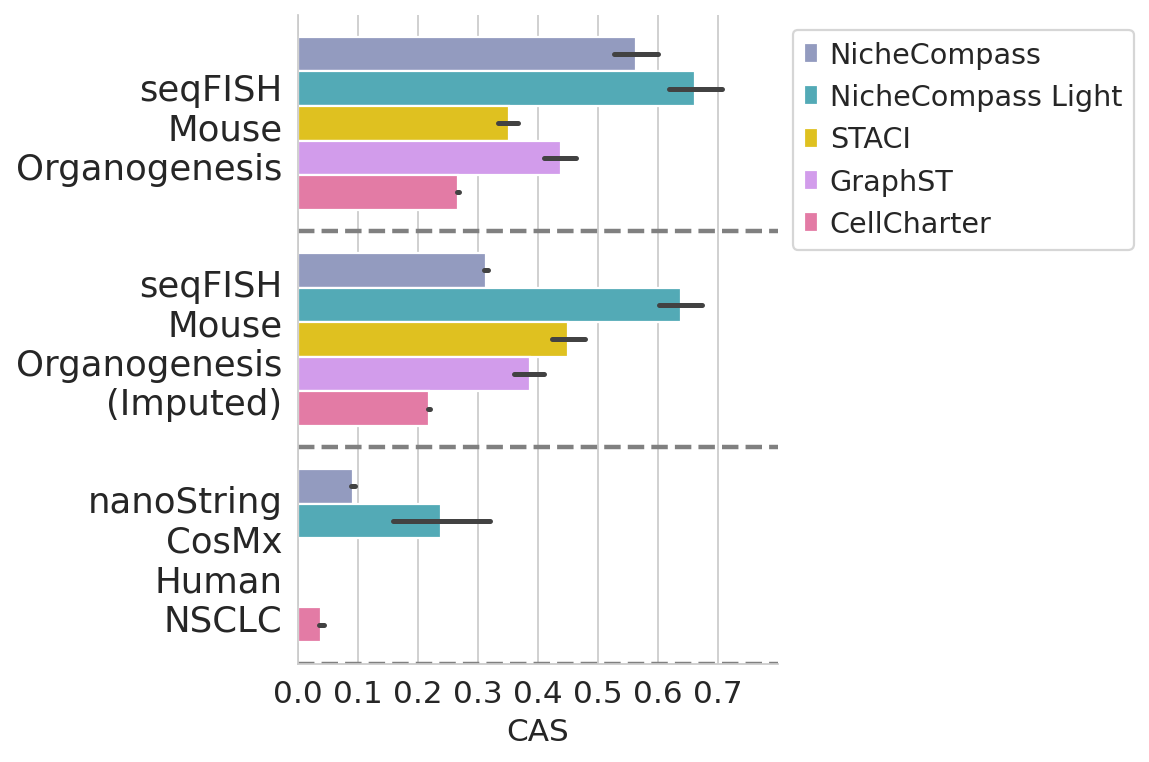

In [37]:
metric = "cas"

sns.set_style("whitegrid")

model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "STACI": "#FFD700",
                 "GraphST": "#D78FF8",
                 "GraphST (No Prior Alignment)": "#b5bd61",
                 "CellCharter": "#F46AA2"}

plt.figure(figsize=(fig_width_8_ticks, fig_height))
ax = sns.barplot(data=summary_df,
                 x=metric,
                 y="dataset",
                 hue="model",
                 orient="h",
                 palette=model_palette
                )
for i in range(summary_df["dataset"].nunique()):
    ax.axhline(0.5 + 1 * i, color='gray', linestyle='--', linewidth=2)

new_labels = [label.get_text().replace(' ', '\n') if i < 3 else label.get_text().replace(' H', '\nH', -1).replace(' N', '\nN', -1).replace(' CosMx', '\nCosMx', -1) for i, label in enumerate(ax.get_yticklabels())]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticklabels(new_labels)
plt.ylabel(None)
plt.xlabel(metric.upper(), fontsize=fontsize)
plt.yticks(fontsize=row_fontsize)
plt.xticks([0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7], fontsize=fontsize)
plt.xlim(0., 0.8)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"{benchmarking_folder_path}/benchmarking_barplot_{metric}_score.svg")
plt.show()

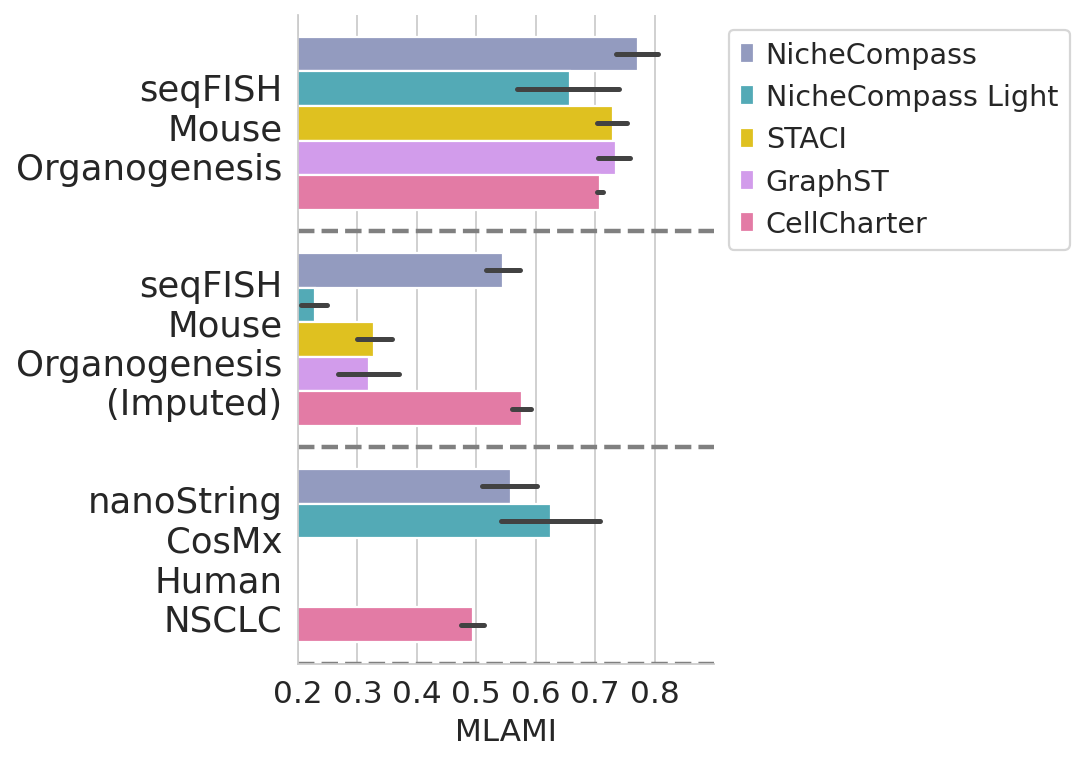

In [38]:
metric = "mlami"

sns.set_style("whitegrid")

model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "STACI": "#FFD700",
                 "GraphST": "#D78FF8",
                 "GraphST (No Prior Alignment)": "#b5bd61",
                 "CellCharter": "#F46AA2"}

plt.figure(figsize=(fig_width_7_ticks, fig_height))
ax = sns.barplot(data=summary_df,
                 x=metric,
                 y="dataset",
                 hue="model",
                 orient="h",
                 palette=model_palette
                )
for i in range(summary_df["dataset"].nunique()):
    ax.axhline(0.5 + 1 * i, color='gray', linestyle='--', linewidth=2)

new_labels = [label.get_text().replace(' ', '\n') if i < 3 else label.get_text().replace(' H', '\nH', -1).replace(' N', '\nN', -1).replace(' CosMx', '\nCosMx', -1) for i, label in enumerate(ax.get_yticklabels())]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticklabels(new_labels)
plt.ylabel(None)
plt.xlabel(metric.upper(), fontsize=fontsize)
plt.yticks(fontsize=row_fontsize)
plt.xticks([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], fontsize=fontsize)
plt.xlim(0.2, 0.9)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"{benchmarking_folder_path}/benchmarking_barplot_{metric}_score.svg")
plt.show()

In [39]:
summary_df["Spatial Conservation Score"] = (summary_df["Global Spatial Conservation Score"] + summary_df["Local Spatial Conservation Score"])/2

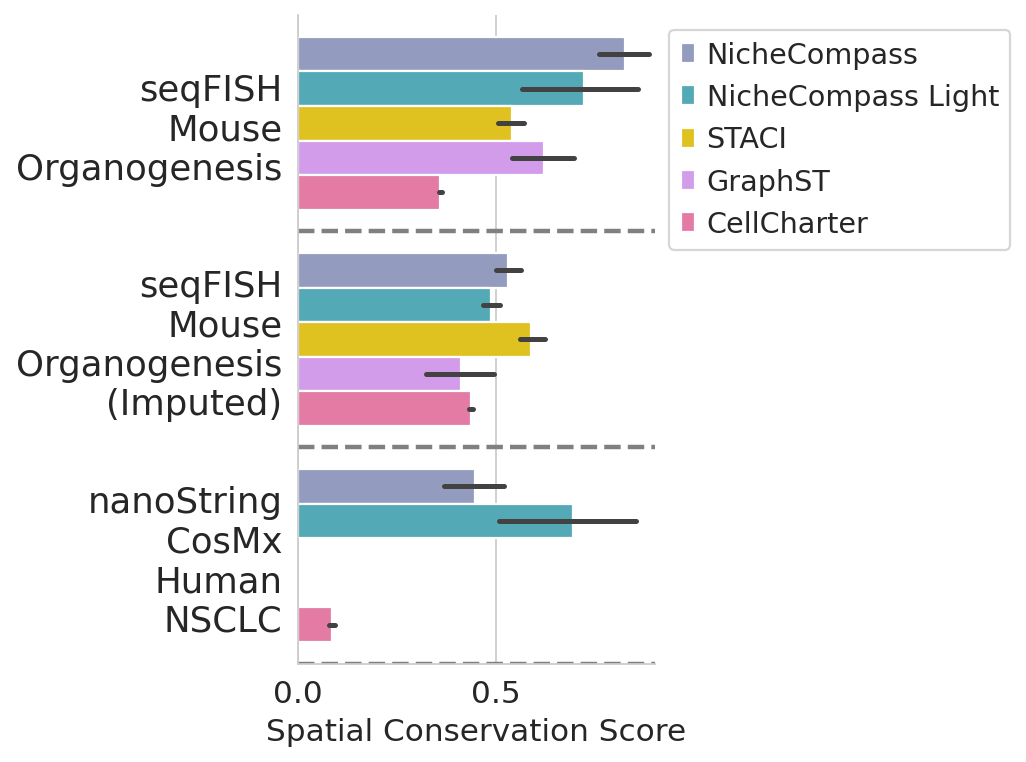

In [41]:
sns.set_style("whitegrid")

model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "STACI": "#FFD700",
                 "GraphST": "#D78FF8",
                 "GraphST (No Prior Alignment)": "#b5bd61",
                 "CellCharter": "#F46AA2"}

plt.figure(figsize=(fig_width_9_ticks*0.85, fig_height))
ax = sns.barplot(data=summary_df,
                 x="Spatial Conservation Score",
                 y="dataset",
                 hue="model",
                 orient="h",
                 palette=model_palette
                )
for i in range(summary_df["dataset"].nunique()):
    ax.axhline(0.5 + 1 * i, color='gray', linestyle='--', linewidth=2)

new_labels = [label.get_text().replace(' ', '\n') if i < 3 else label.get_text().replace(' H', '\nH', -1).replace(' N', '\nN', -1).replace(' CosMx', '\nCosMx', -1) for i, label in enumerate(ax.get_yticklabels())]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticklabels(new_labels)
plt.ylabel(None)
plt.xlabel("Spatial Conservation Score", fontsize=fontsize)
plt.yticks(fontsize=row_fontsize)
#plt.xticks([0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], fontsize=fontsize)
plt.xlim(0., 0.9)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"{benchmarking_folder_path}/benchmarking_barplot_spatial_conservation_score.svg")
plt.show()

In [42]:
temp_df = summary_df[summary_df["dataset"] == "seqFISH Mouse Organogenesis"]
metrics_temp_df = temp_df.groupby("model")[["Spatial Conservation Score"]].mean()
metrics_temp_df.iloc[1] / metrics_temp_df.iloc[0] # NC vs GraphST

Spatial Conservation Score    1.735431
dtype: float64

In [43]:
temp_df = summary_df[summary_df["dataset"] == "seqFISH Mouse Organogenesis (Imputed)"]
metrics_temp_df = temp_df.groupby("model")[["Spatial Conservation Score"]].mean()
metrics_temp_df.iloc[1] / metrics_temp_df.iloc[3] # NC vs STACI

Spatial Conservation Score    0.843066
dtype: float64

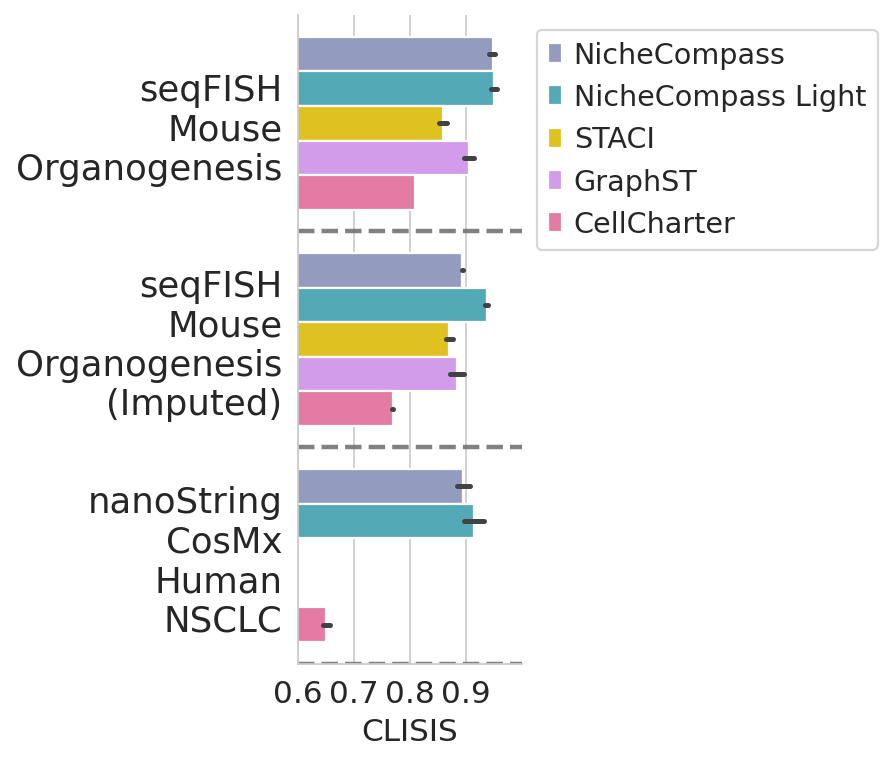

In [47]:
metric = "clisis"

sns.set_style("whitegrid")

model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "STACI": "#FFD700",
                 "GraphST": "#D78FF8",
                 "GraphST (No Prior Alignment)": "#b5bd61",
                 "CellCharter": "#F46AA2"}

plt.figure(figsize=(fig_width_4_ticks, fig_height))
ax = sns.barplot(data=summary_df,
                 x=metric,
                 y="dataset",
                 hue="model",
                 orient="h",
                 palette=model_palette
                )
for i in range(summary_df["dataset"].nunique()):
    ax.axhline(0.5 + 1 * i, color='gray', linestyle='--', linewidth=2)

new_labels = [label.get_text().replace(' ', '\n') if i < 3 else label.get_text().replace(' H', '\nH', -1).replace(' N', '\nN', -1).replace(' CosMx', '\nCosMx', -1) for i, label in enumerate(ax.get_yticklabels())]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticklabels(new_labels)
plt.ylabel(None)
plt.xlabel(metric.upper(), fontsize=fontsize)
plt.yticks(fontsize=row_fontsize)
plt.xticks([0.6, 0.7, 0.8, 0.9], fontsize=fontsize)
plt.xlim(0.6, 1.0)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"{benchmarking_folder_path}/benchmarking_barplot_{metric}_score.svg")
plt.show()

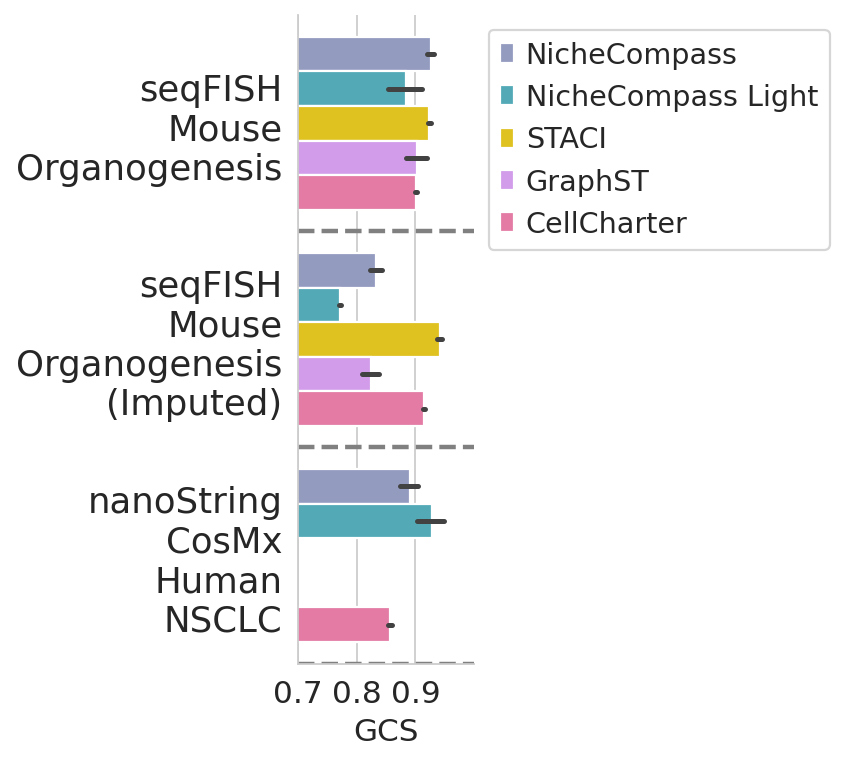

In [48]:
metric = "gcs"

sns.set_style("whitegrid")

model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "STACI": "#FFD700",
                 "GraphST": "#D78FF8",
                 "GraphST (No Prior Alignment)": "#b5bd61",
                 "CellCharter": "#F46AA2"}

plt.figure(figsize=(fig_width_3_ticks, fig_height))
ax = sns.barplot(data=summary_df,
                 x=metric,
                 y="dataset",
                 hue="model",
                 orient="h",
                 palette=model_palette
                )
for i in range(summary_df["dataset"].nunique()):
    ax.axhline(0.5 + 1 * i, color='gray', linestyle='--', linewidth=2)

new_labels = [label.get_text().replace(' ', '\n') if i < 3 else label.get_text().replace(' H', '\nH', -1).replace(' N', '\nN', -1).replace(' CosMx', '\nCosMx', -1) for i, label in enumerate(ax.get_yticklabels())]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticklabels(new_labels)
plt.ylabel(None)
plt.xlabel(metric.upper(), fontsize=fontsize)
plt.yticks(fontsize=row_fontsize)
plt.xticks([0.7, 0.8, 0.9], fontsize=fontsize)
plt.xlim(0.7, 1.0)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"{benchmarking_folder_path}/benchmarking_barplot_{metric}_score.svg")
plt.show()

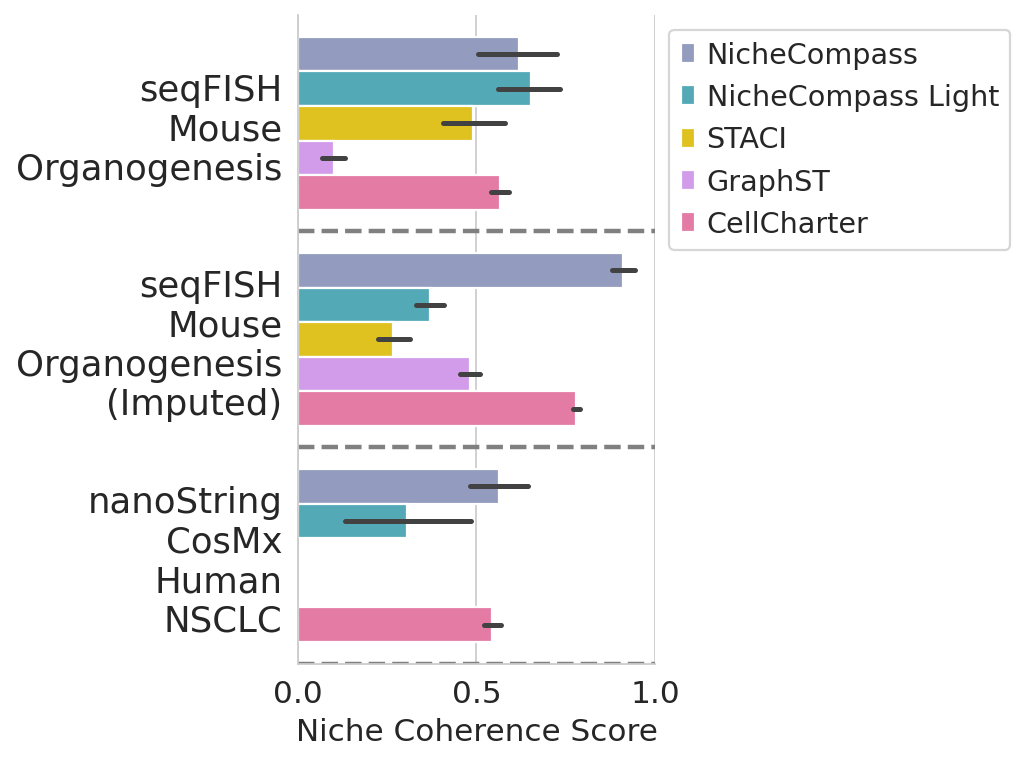

In [49]:
sns.set_style("whitegrid")

model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "STACI": "#FFD700",
                 "GraphST": "#D78FF8",
                 "GraphST (No Prior Alignment)": "#b5bd61",
                 "CellCharter": "#F46AA2"}

plt.figure(figsize=(fig_width_9_ticks*0.85, fig_height))
ax = sns.barplot(data=summary_df,
                 x="Niche Coherence Score",
                 y="dataset",
                 hue="model",
                 orient="h",
                 palette=model_palette
                )
for i in range(summary_df["dataset"].nunique()):
    ax.axhline(0.5 + 1 * i, color='gray', linestyle='--', linewidth=2)

new_labels = [label.get_text().replace(' ', '\n') if i < 3 else label.get_text().replace(' H', '\nH', -1).replace(' N', '\nN', -1).replace(' CosMx', '\nCosMx', -1) for i, label in enumerate(ax.get_yticklabels())]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticklabels(new_labels)
plt.ylabel(None)
plt.xlabel("Niche Coherence Score", fontsize=fontsize)
plt.yticks(fontsize=row_fontsize)
#plt.xticks([0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], fontsize=fontsize)
plt.xlim(0., 1.0)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"{benchmarking_folder_path}/benchmarking_barplot_niche_coherence_score.svg")
plt.show()

In [50]:
temp_df = summary_df[summary_df["dataset"] == "seqFISH Mouse Organogenesis"]
metrics_temp_df = temp_df.groupby("model")[["Niche Coherence Score"]].mean()
metrics_temp_df.iloc[1] / metrics_temp_df.iloc[3] # NC vs STACI

Niche Coherence Score    0.155809
dtype: float64

In [51]:
temp_df = summary_df[summary_df["dataset"] == "seqFISH Mouse Organogenesis (Imputed)"]
metrics_temp_df = temp_df.groupby("model")[["Niche Coherence Score"]].mean()
metrics_temp_df.iloc[1] / metrics_temp_df.iloc[0] # NC vs GraphST

Niche Coherence Score    0.616828
dtype: float64

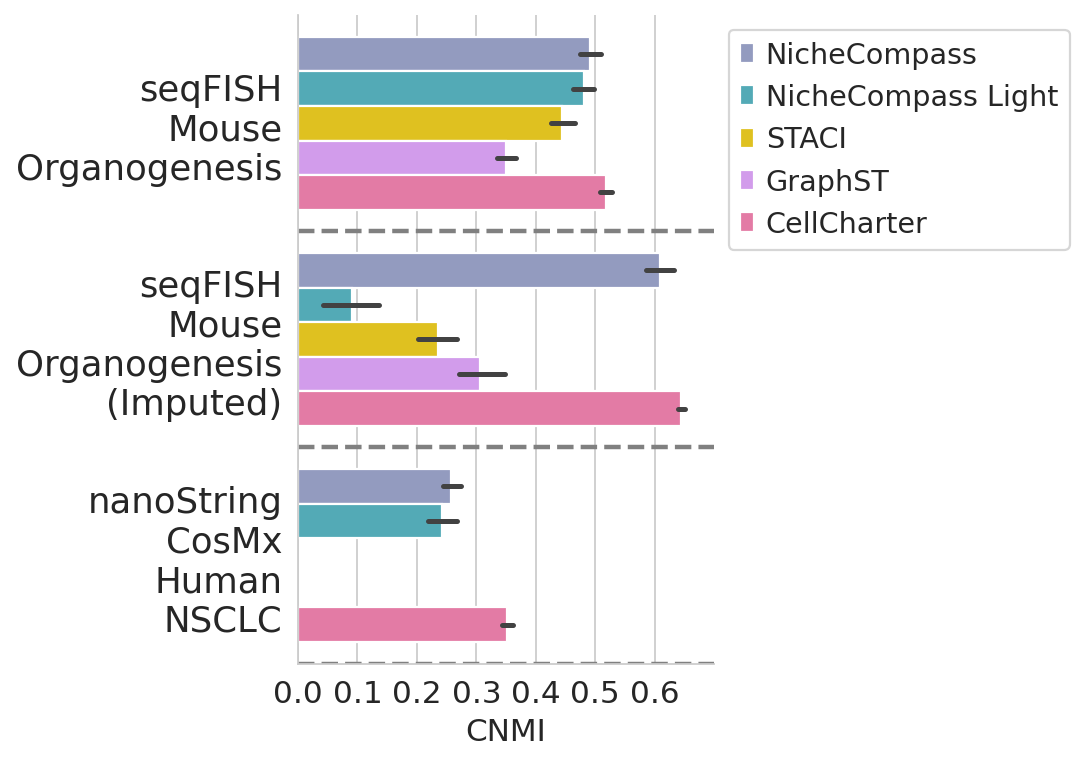

In [52]:
metric = "cnmi"

sns.set_style("whitegrid")

model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "STACI": "#FFD700",
                 "GraphST": "#D78FF8",
                 "GraphST (No Prior Alignment)": "#b5bd61",
                 "CellCharter": "#F46AA2"}

plt.figure(figsize=(fig_width_7_ticks, fig_height))
ax = sns.barplot(data=summary_df,
                 x=metric,
                 y="dataset",
                 hue="model",
                 orient="h",
                 palette=model_palette
                )
for i in range(summary_df["dataset"].nunique()):
    ax.axhline(0.5 + 1 * i, color='gray', linestyle='--', linewidth=2)

new_labels = [label.get_text().replace(' ', '\n') if i < 3 else label.get_text().replace(' H', '\nH', -1).replace(' N', '\nN', -1).replace(' CosMx', '\nCosMx', -1) for i, label in enumerate(ax.get_yticklabels())]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticklabels(new_labels)
plt.ylabel(None)
plt.xlabel(metric.upper(), fontsize=fontsize)
plt.yticks(fontsize=row_fontsize)
plt.xticks([0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6], fontsize=fontsize)
plt.xlim(0., 0.7)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"{benchmarking_folder_path}/benchmarking_barplot_{metric}_score.svg")
plt.show()

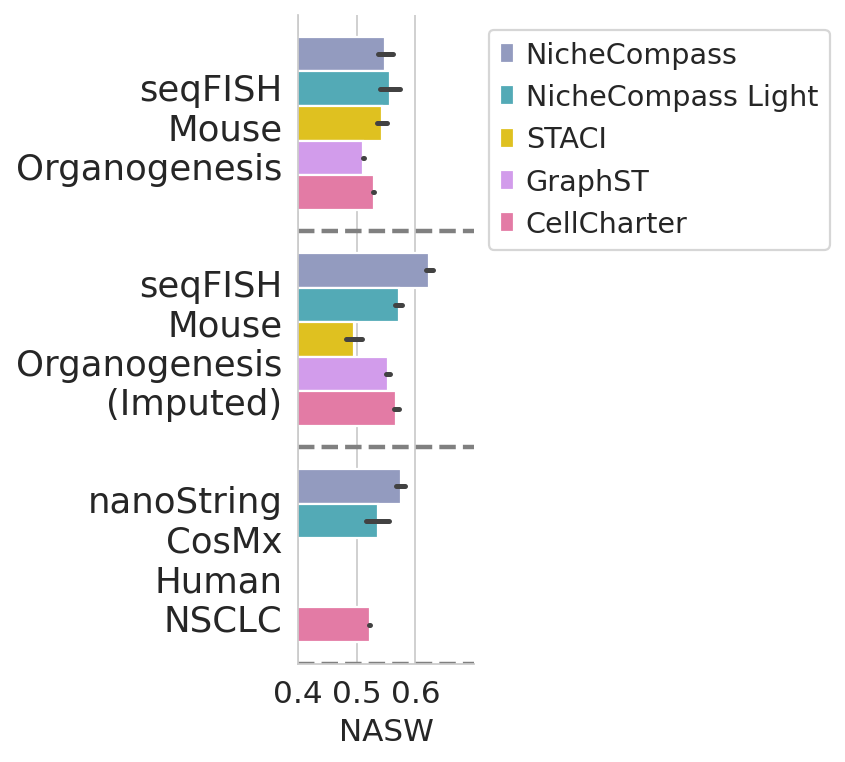

In [53]:
metric = "nasw"

sns.set_style("whitegrid")

model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "STACI": "#FFD700",
                 "GraphST": "#D78FF8",
                 "GraphST (No Prior Alignment)": "#b5bd61",
                 "CellCharter": "#F46AA2"}

plt.figure(figsize=(fig_width_3_ticks, fig_height))
ax = sns.barplot(data=summary_df,
                 x=metric,
                 y="dataset",
                 hue="model",
                 orient="h",
                 palette=model_palette
                )
for i in range(summary_df["dataset"].nunique()):
    ax.axhline(0.5 + 1 * i, color='gray', linestyle='--', linewidth=2)

new_labels = [label.get_text().replace(' ', '\n') if i < 3 else label.get_text().replace(' H', '\nH', -1).replace(' N', '\nN', -1).replace(' CosMx', '\nCosMx', -1) for i, label in enumerate(ax.get_yticklabels())]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticklabels(new_labels)
plt.ylabel(None)
plt.xlabel(metric.upper(), fontsize=fontsize)
plt.yticks(fontsize=row_fontsize)
plt.xticks([0.4, 0.5, 0.6], fontsize=fontsize)
plt.xlim(0.4, 0.7)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"{benchmarking_folder_path}/benchmarking_barplot_{metric}_score.svg")
plt.show()

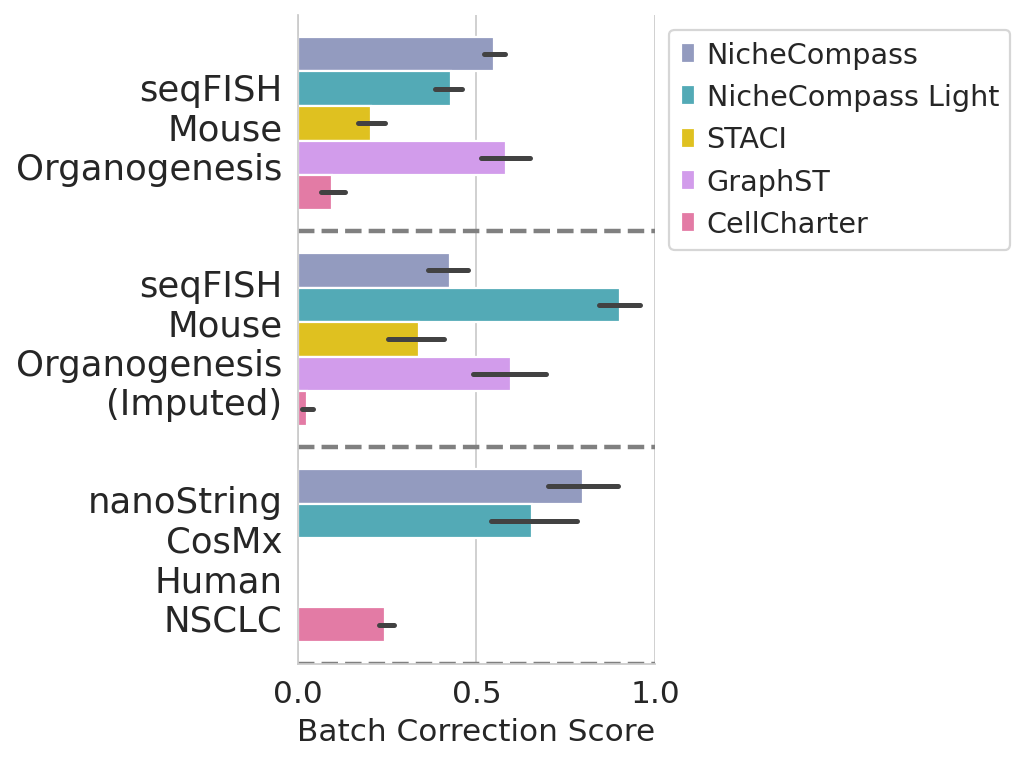

In [55]:
sns.set_style("whitegrid")

model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "STACI": "#FFD700",
                 "GraphST": "#D78FF8",
                 "GraphST (No Prior Alignment)": "#b5bd61",
                 "CellCharter": "#F46AA2"}

plt.figure(figsize=(fig_width_9_ticks*0.85, fig_height))
ax = sns.barplot(data=summary_df,
                 x="Batch Correction Score",
                 y="dataset",
                 hue="model",
                 orient="h",
                 palette=model_palette
                )
for i in range(summary_df["dataset"].nunique()):
    ax.axhline(0.5 + 1 * i, color='gray', linestyle='--', linewidth=2)

new_labels = [label.get_text().replace(' ', '\n') if i < 3 else label.get_text().replace(' H', '\nH', -1).replace(' N', '\nN', -1).replace(' CosMx', '\nCosMx', -1) for i, label in enumerate(ax.get_yticklabels())]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticklabels(new_labels)
plt.ylabel(None)
plt.xlabel("Batch Correction Score", fontsize=fontsize)
plt.yticks(fontsize=row_fontsize)
#plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], fontsize=fontsize)
plt.xlim(0., 1.0)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"{benchmarking_folder_path}/benchmarking_barplot_batch_correction_score.svg")
plt.show()

In [56]:
temp_df = summary_df[summary_df["dataset"] == "seqFISH Mouse Organogenesis"]
metrics_temp_df = temp_df.groupby("model")[["Batch Correction Score"]].mean()
metrics_temp_df.iloc[1] / metrics_temp_df.iloc[0]

Batch Correction Score    6.139101
dtype: float64

In [57]:
temp_df = summary_df[summary_df["dataset"] == "seqFISH Mouse Organogenesis (Imputed)"]
metrics_temp_df = temp_df.groupby("model")[["Batch Correction Score"]].mean()
metrics_temp_df.iloc[1] / metrics_temp_df.iloc[0]

Batch Correction Score    23.096222
dtype: float64

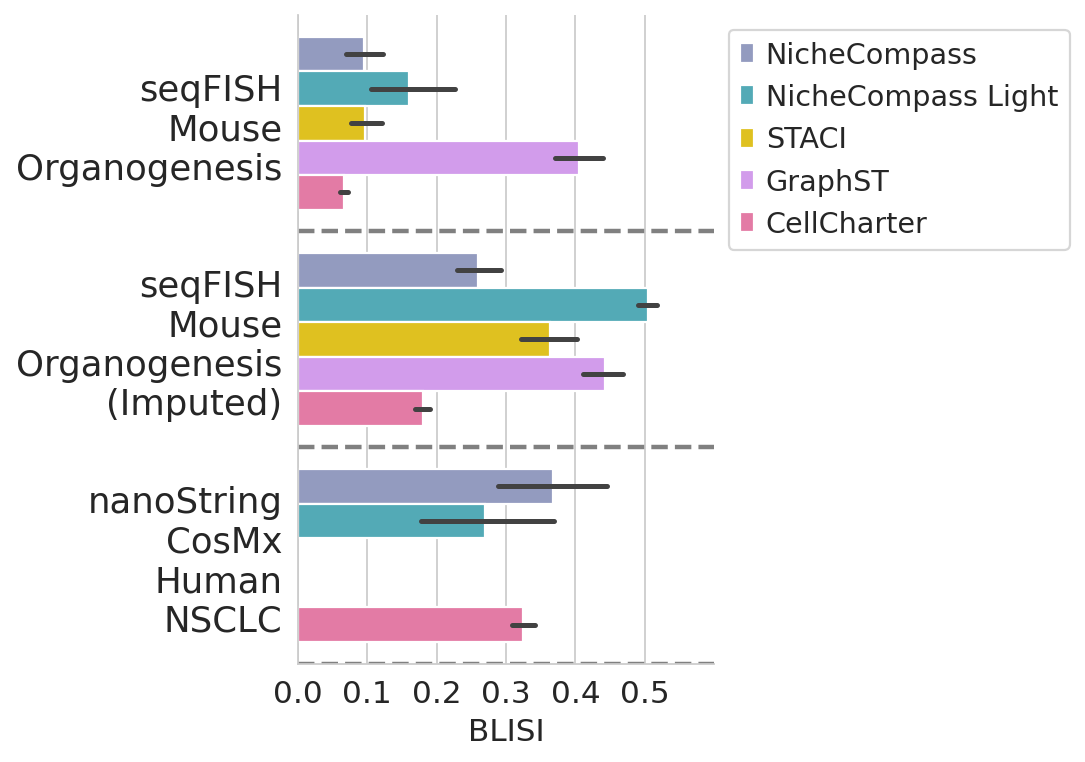

In [58]:
metric = "blisi"

sns.set_style("whitegrid")

model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "STACI": "#FFD700",
                 "GraphST": "#D78FF8",
                 "GraphST (No Prior Alignment)": "#b5bd61",
                 "CellCharter": "#F46AA2"}

plt.figure(figsize=(fig_width_7_ticks, fig_height))
ax = sns.barplot(data=summary_df,
                 x=metric,
                 y="dataset",
                 hue="model",
                 orient="h",
                 palette=model_palette
                )
for i in range(summary_df["dataset"].nunique()):
    ax.axhline(0.5 + 1 * i, color='gray', linestyle='--', linewidth=2)

new_labels = [label.get_text().replace(' ', '\n') if i < 3 else label.get_text().replace(' H', '\nH', -1).replace(' N', '\nN', -1).replace(' CosMx', '\nCosMx', -1) for i, label in enumerate(ax.get_yticklabels())]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticklabels(new_labels)
plt.ylabel(None)
plt.xlabel(metric.upper(), fontsize=fontsize)
plt.yticks(fontsize=row_fontsize)
plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5], fontsize=fontsize)
plt.xlim(0., 0.6)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"{benchmarking_folder_path}/benchmarking_barplot_{metric}_score.svg")
plt.show()

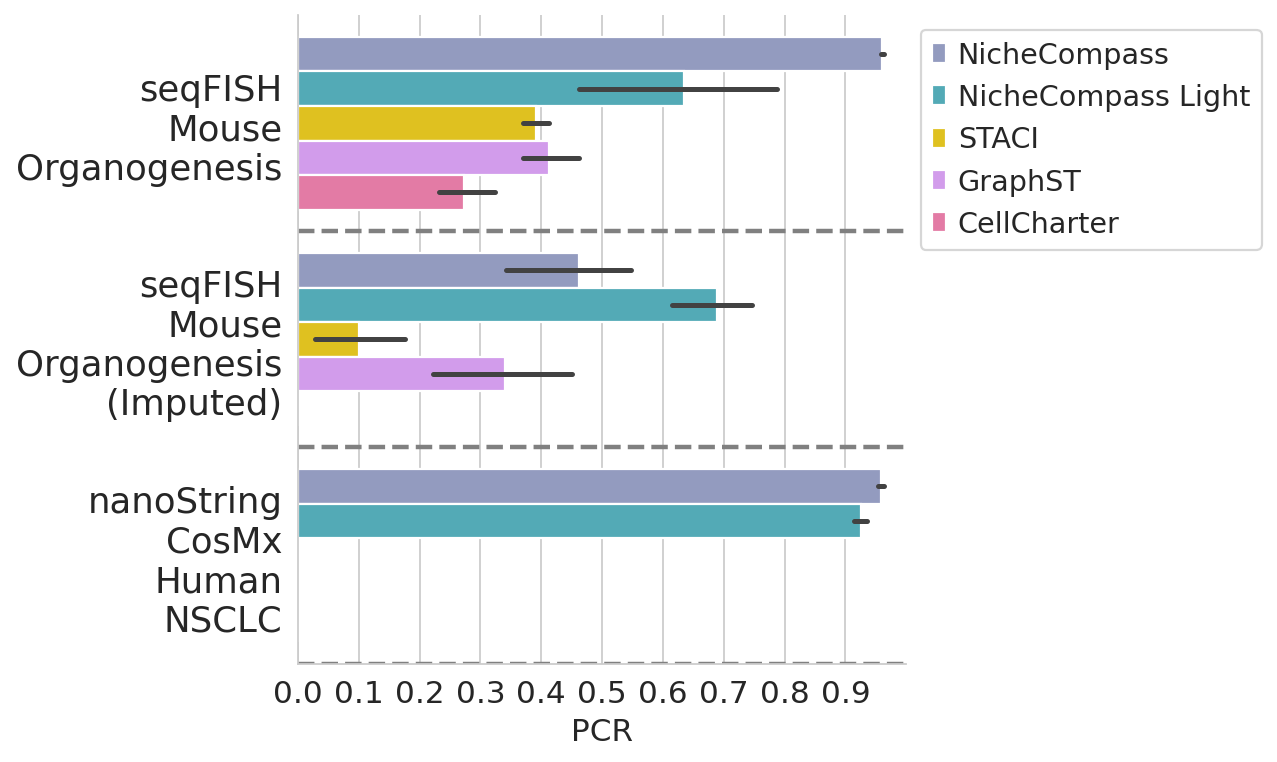

In [61]:
metric = "pcr"

sns.set_style("whitegrid")

model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "STACI": "#FFD700",
                 "GraphST": "#D78FF8",
                 "GraphST (No Prior Alignment)": "#b5bd61",
                 "CellCharter": "#F46AA2"}

plt.figure(figsize=(fig_width_10_ticks, fig_height))
ax = sns.barplot(data=summary_df,
                 x=metric,
                 y="dataset",
                 hue="model",
                 orient="h",
                 palette=model_palette
                )
for i in range(summary_df["dataset"].nunique()):
    ax.axhline(0.5 + 1 * i, color='gray', linestyle='--', linewidth=2)

new_labels = [label.get_text().replace(' ', '\n') if i < 3 else label.get_text().replace(' H', '\nH', -1).replace(' N', '\nN', -1).replace(' CosMx', '\nCosMx', -1) for i, label in enumerate(ax.get_yticklabels())]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticklabels(new_labels)
plt.ylabel(None)
plt.xlabel(metric.upper(), fontsize=fontsize)
plt.yticks(fontsize=row_fontsize)
plt.xticks([0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], fontsize=fontsize)
plt.xlim(0., 1.0)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"{benchmarking_folder_path}/benchmarking_barplot_{metric}_score.svg")
plt.show()

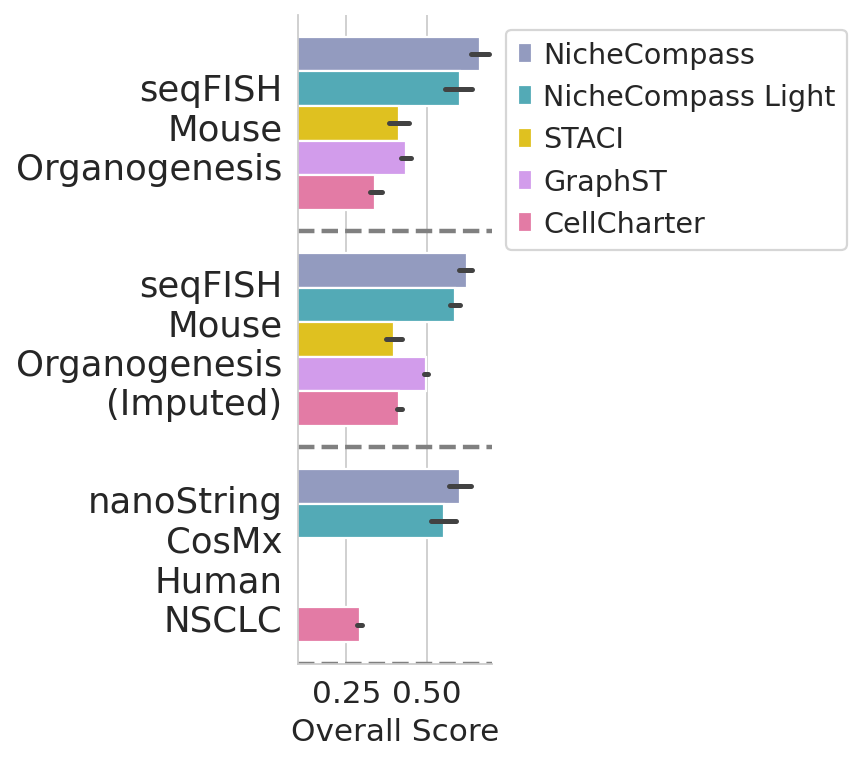

In [67]:
## sns.set_style("whitegrid")

model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "STACI": "#FFD700",
                 "GraphST": "#D78FF8",
                 "GraphST (No Prior Alignment)": "#b5bd61",
                 "CellCharter": "#F46AA2"}

plt.figure(figsize=(fig_width_6_ticks*0.85, fig_height))
ax = sns.barplot(data=summary_df,
                 x="Overall Score",
                 y="dataset",
                 hue="model",
                 orient="h",
                 palette=model_palette
                )
for i in range(summary_df["dataset"].nunique()):
    ax.axhline(0.5 + 1 * i, color='gray', linestyle='--', linewidth=2)

new_labels = [label.get_text().replace(' ', '\n') if i < 3 else label.get_text().replace(' H', '\nH', -1).replace(' N', '\nN', -1).replace(' CosMx', '\nCosMx', -1) for i, label in enumerate(ax.get_yticklabels())]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticklabels(new_labels)
plt.ylabel(None)
plt.xlabel("Overall Score", fontsize=fontsize)
plt.yticks(fontsize=row_fontsize)
#plt.xticks([0.3, 0.4, 0.5, 0.6], fontsize=fontsize)
plt.xlim(0.1, 0.7)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"{benchmarking_folder_path}/benchmarking_barplot_overall_score.svg")
plt.show()

In [70]:
temp_df = summary_df[summary_df["dataset"] == "seqFISH Mouse Organogenesis"]
metrics_temp_df = temp_df.groupby("model")[["Overall Score"]].mean()
metrics_temp_df.iloc[2] / metrics_temp_df.iloc[1] # NC vs GraphST

Overall Score    1.524233
dtype: float64

In [73]:
temp_df = summary_df[summary_df["dataset"] == "seqFISH Mouse Organogenesis (Imputed)"]
metrics_temp_df = temp_df.groupby("model")[["Overall Score"]].mean()
metrics_temp_df.iloc[2] / metrics_temp_df.iloc[1] # NC vs GraphST

Overall Score    1.253341
dtype: float64

In [76]:
temp_df = summary_df[summary_df["dataset"] == "nanoString CosMx Human NSCLC"]
metrics_temp_df = temp_df.groupby("model")[["Overall Score"]].mean()
metrics_temp_df.iloc[2] / metrics_temp_df.iloc[0] # NC vs CellCharter

Overall Score    2.069953
dtype: float64

### 2.2 Method Comparison Visualizations

#### 2.1.1 nanoString CosMx SMI Human Non-Small-Cell Lung Cancer (NSCLC)

In [ ]:
sns.color_palette("colorblind").as_hex()

In [ ]:
print(sns.color_palette("colorblind").as_hex())

##### 2.1.1.1 10 Percent Subsample

In [ ]:
### Fig. 3e: 10 pct subsample comparison NC vs STACI vs GraphST vs CellCharter ###

# NicheCompass with FoV embedding
dataset = "nanostring_cosmx_human_nsclc_subsample_10pct"
run_number = 2
model = "nichecompass_gatv2conv"
latent_leiden_resolution = 0.21
timestamp = "26082023_191240_1"
adata = sc.read_h5ad(f"{artifact_folder_path}/{dataset}/models/gatv2conv_sample_integration_method_benchmarking/{timestamp}/run{run_number}/{dataset}_gatv2conv_sample_integration_method_benchmarking.h5ad")

print("\nComputing UMAP embedding...")
sc.tl.umap(adata,
           neighbors_key=f"nichecompass_latent")

print("\nComputing Leiden clustering...")
sc.tl.leiden(adata=adata,
             resolution=latent_leiden_resolution,
             key_added=f"latent_leiden_{latent_leiden_resolution}",
             neighbors_key=f"nichecompass_latent")

niche_annotation_dict = {
    "0": "Endothelial/Stroma",
    "1": "Tumor 1",
    "2": "Lymphoid Structures",
    "3": "Epithelial/Stroma",
    "4": "Neutrophil/Myeloid/Stroma",
    "5": "Plasmablast/Stroma",
    "6": "Tumor-Stroma Boundary",
    "7": "Tumor 2"}

latent_cluster_colors = create_new_color_dict(
    adata=adata,
    cat_key=f"latent_leiden_{latent_leiden_resolution}")

adata.obs["niche"] = adata.obs[f"latent_leiden_{latent_leiden_resolution}"].map(niche_annotation_dict)
niche_colors = {niche: latent_cluster_colors[cluster] for cluster, niche in niche_annotation_dict.items()}

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Niches",
        model_label={model},
        cat_key="niche",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=niche_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/{dataset}_niches_{model}.svg")

cell_type_colors = create_new_color_dict(
    adata=adata,
    color_palette="cell_type_30",
    cat_key="cell_type")

adata_temp = adata[adata.obs["niche"].isin(["Endothelial/Stroma",
                                            "Plasmablast/Stroma",
                                            "Tumor-Stroma Boundary"])]

tmp = pd.crosstab(adata_temp.obs["niche"], adata_temp.obs["cell_type"], normalize='index')
tmp.rename(index={"Tumor-Stroma Boundary": "Tumor-Stroma\nBoundary"},
           inplace=True)
ax = tmp.plot.barh(color=cell_type_colors, stacked=True, figsize=(6, 2)).legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.yticks(fontsize=14)
plt.xlabel("Cell Type Proportions", fontsize=16)
plt.savefig(f"{benchmarking_folder_path}/{model}_{dataset}_niche_cell_type_proportions.svg", bbox_inches='tight')

adata.obs["batch"] = adata.obs["batch"].replace({"lung5_rep1": "Replicate 1",
                                                 "lung5_rep2": "Replicate 2",
                                                 "lung5_rep3": "Replicate 3"})

batch_colors = {"Replicate 1": sns.color_palette("colorblind").as_hex()[0],
                "Replicate 2": sns.color_palette("colorblind").as_hex()[3],
                "Replicate 3": sns.color_palette("colorblind").as_hex()[8]}

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Batches",
        model_label={model},
        cat_key="batch",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=batch_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/{dataset}_batches_{model}.svg")

# GraphST with prior alignment through PASTE algorithm
model = "graphst_paste"
latent_leiden_resolution = 0.4
adata = sc.read_h5ad(f"{artifact_folder_path}/sample_integration_method_benchmarking/{dataset}_{model}.h5ad")

print("\nComputing UMAP embedding...")
sc.tl.umap(adata,
           neighbors_key=f"graphst_latent_run{run_number}")

print("\nComputing Leiden clustering...")
sc.tl.leiden(adata=adata,
             resolution=latent_leiden_resolution,
             key_added=f"latent_leiden_{latent_leiden_resolution}",
             neighbors_key=f"graphst_latent_run{run_number}")

latent_cluster_colors = {
    "0": "#66C5CC",
    "1": "#9EB9F3",
    "2": "#C9DB74",
    "3": "#DCB0F2",
    "4": "#8B008B",
    "5": "#FE88B1",
    "6": "#F6CF71",
    "7": "#F89C74"}

niche_annotation_dict = {
    "0": "Endothelial/Stroma (Replicate 1 & 3)",
    "1": "Tumor 1",
    "2": "Lymphoid Structures",
    "3": "Neutrophil/Myeloid/Stroma",
    "4": "Endothelial/Stroma (Replicate 2)",
    "5": "Tumor-Stroma Boundary",
    "6": "Epithelial/Stroma",
    "7": "Tumor 2"}

adata.obs["niche"] = adata.obs[f"latent_leiden_{latent_leiden_resolution}"].map(niche_annotation_dict)
niche_colors = {niche: latent_cluster_colors[cluster] for cluster, niche in niche_annotation_dict.items()}

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Niches",
        model_label={model},
        cat_key=f"niche",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=niche_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/{dataset}_niches_{model}.svg")

cell_type_colors = create_new_color_dict(
    adata=adata,
    color_palette="cell_type_30",
    cat_key="cell_type")

adata_temp = adata[adata.obs["niche"].isin(["Endothelial/Stroma (Replicate 2)",
                                            "Endothelial/Stroma (Replicate 1 & 3)",
                                            "Tumor-Stroma Boundary"])]

tmp = pd.crosstab(adata_temp.obs["niche"], adata_temp.obs["cell_type"], normalize='index')
tmp.rename(index={"Endothelial/Stroma (Replicate 2)": "Endothelial/Stroma\n(Replicate 2)",
                  "Endothelial/Stroma (Replicate 1 & 3)": "Endothelial/Stroma\n(Replicate 1 & 3)",
                  "Tumor-Stroma Boundary": "Tumor-Stroma\nBoundary"},
           inplace=True)
ax = tmp.plot.barh(color=cell_type_colors, stacked=True, figsize=(6, 2)).legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.yticks(fontsize=14)
plt.xlabel("Cell Type Proportions", fontsize=16)
plt.savefig(f"{benchmarking_folder_path}/{model}_{dataset}_niche_cell_type_proportions.svg", bbox_inches='tight')

adata.obs["batch"] = adata.obs["batch"].replace({"lung5_rep1": "Replicate 1",
                                                 "lung5_rep2": "Replicate 2",
                                                 "lung5_rep3": "Replicate 3"})

batch_colors = {"Replicate 1": sns.color_palette("colorblind").as_hex()[0],
                "Replicate 2": sns.color_palette("colorblind").as_hex()[3],
                "Replicate 3": sns.color_palette("colorblind").as_hex()[8]}

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Batches",
        model_label={model},
        cat_key="batch",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=batch_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/{dataset}_batches_{model}.svg")

# STACI
model = "staci"
run_number = 1
latent_leiden_resolution = 0.19
adata = sc.read_h5ad(f"{artifact_folder_path}/sample_integration_method_benchmarking/{dataset}_{model}.h5ad")

sc.pp.neighbors(adata,
                use_rep=f"staci_latent_run{run_number}",
                key_added=f"staci_latent_run{run_number}")

print("\nComputing UMAP embedding...")
sc.tl.umap(adata,
           neighbors_key=f"staci_latent_run{run_number}")

print("\nComputing Leiden clustering...")
sc.tl.leiden(adata=adata,
             resolution=latent_leiden_resolution,
             key_added=f"latent_leiden_{latent_leiden_resolution}",
             neighbors_key=f"staci_latent_run{run_number}")

latent_cluster_colors = {
    "0": "#9EB9F3",
    "1": "#F6CF71",
    "2": "#C9DB74",
    "3": "#66C5CC",
    "4": "#87C55F",
    "5": "#DCB0F2",
    "6": "#8B008B",
    "7": "#F89C74"}

niche_annotation_dict = {
    "0": "Tumor 1",
    "1": "Epithelial/Stroma",
    "2": "Lymphoid Structures",
    "3": "Endothelial/Stroma (Replicate 1 & 3)",
    "4": "Plasmablast/Stroma",
    "5": "Neutrophil/Myeloid/Stroma",
    "6": "Endothelial/Stroma (Replicate 2)",
    "7": "Tumor 2"}

adata.obs["niche"] = adata.obs[f"latent_leiden_{latent_leiden_resolution}"].map(niche_annotation_dict)
niche_colors = {niche: latent_cluster_colors[cluster] for cluster, niche in niche_annotation_dict.items()}

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Niches",
        model_label={model},
        cat_key=f"niche",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=niche_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/{dataset}_niches_{model}.svg")

cell_type_colors = create_new_color_dict(
    adata=adata,
    color_palette="cell_type_30",
    cat_key="cell_type")

adata_temp = adata[adata.obs["niche"].isin(["Endothelial/Stroma (Replicate 2)",
                                            "Endothelial/Stroma (Replicate 1 & 3)",
                                            "Plasmablast/Stroma"])]

tmp = pd.crosstab(adata_temp.obs["niche"], adata_temp.obs["cell_type"], normalize='index')
tmp.rename(index={"Endothelial/Stroma (Replicate 1 & 3)": "Endothelial/Stroma\n(Replicate 1 & 3)",
                  "Endothelial/Stroma (Replicate 2)": "Endothelial/Stroma\n(Replicate 2)"}, inplace=True)
ax = tmp.plot.barh(color=cell_type_colors, stacked=True, figsize=(6, 2)).legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.yticks(fontsize=14)
plt.xlabel("Cell Type Proportions", fontsize=16)
plt.savefig(f"{benchmarking_folder_path}/{model}_{dataset}_niche_cell_type_proportions.svg", bbox_inches='tight')

adata.obs["batch"] = adata.obs["batch"].replace({"lung5_rep1": "Replicate 1",
                                                 "lung5_rep2": "Replicate 2",
                                                 "lung5_rep3": "Replicate 3"})

batch_colors = {"Replicate 1": sns.color_palette("colorblind").as_hex()[0],
                "Replicate 2": sns.color_palette("colorblind").as_hex()[3],
                "Replicate 3": sns.color_palette("colorblind").as_hex()[8]}

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Batches",
        model_label={model},
        cat_key="batch",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=batch_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/{dataset}_batches_{model}.svg")

# CellCharter
model = "cellcharter"
adata = sc.read_h5ad(f"{artifact_folder_path}/sample_integration_method_benchmarking/{dataset}_{model}.h5ad")

print("\nComputing UMAP embedding...")
sc.tl.umap(adata,
           neighbors_key=f"{model}_latent_run{run_number}")

print("\nComputing CellCharter clustering...")
# Use cellcharter clustering
gmm = cc.tl.Cluster(
    n_clusters=8, 
    random_state=1,
    # If running on GPU
    #trainer_params=dict(accelerator='gpu', devices=1)
)
gmm.fit(adata, use_rep=f"{model}_latent_run{run_number}")
adata.obs["spatial_clusters"] = gmm.predict(adata, use_rep=f"{model}_latent_run{run_number}").astype("str")

latent_cluster_colors = {
    "0": "#87C55F",
    "1": "#DCB0F2",
    "2": "#8B008B",
    "3": "#9EB9F3",
    "4": "#1E90FF",
    "5": "#FE88B1",
    "6": "#C9DB74",
    "7": "#66C5CC"}

niche_annotation_dict = {
    "0": "Plasmablast/Stroma",
    "1": "Neutrophil/Myeloid/Stroma",
    "2": "Endothelial/Stroma (Replicate 2)",
    "3": "Tumor",
    "4": "Lymphoid Structures 2",
    "5": "Tumor-Stroma Boundary",
    "6": "Lymphoid Structures",
    "7": "Endothelial/Stroma (Replicate 1 & 3)"}

adata.obs["niche"] = adata.obs["spatial_clusters"].map(niche_annotation_dict)
niche_colors = {niche: latent_cluster_colors[cluster] for cluster, niche in niche_annotation_dict.items()}

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Niches",
        model_label={model},
        cat_key=f"niche",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=niche_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/{dataset}_niches_{model}.svg")

cell_type_colors = create_new_color_dict(
    adata=adata,
    color_palette="cell_type_30",
    cat_key="cell_type")

adata_temp = adata[adata.obs["niche"].isin(["Endothelial/Stroma (Replicate 2)",
                                            "Endothelial/Stroma (Replicate 1 & 3)",
                                            "Tumor-Stroma Boundary",
                                            "Plasmablast/Stroma"])]

tmp = pd.crosstab(adata_temp.obs["niche"], adata_temp.obs["cell_type"], normalize='index')
tmp.rename(index={"Endothelial/Stroma (Replicate 2)": "Endothelial/Stroma\n(Replicate 2)",
                  "Endothelial/Stroma (Replicate 1 & 3)": "Endothelial/Stroma\n(Replicate 1 & 3)",
                  "Tumor-Stroma Boundary": "Tumor-Stroma\nBoundary"},
           inplace=True)
ax = tmp.plot.barh(color=cell_type_colors, stacked=True, figsize=(6, 2)).legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.yticks(fontsize=14)
plt.xlabel("Cell Type Proportions", fontsize=16)
plt.savefig(f"{benchmarking_folder_path}/{model}_{dataset}_niche_cell_type_proportions.svg", bbox_inches='tight')

adata.obs["batch"] = adata.obs["batch"].replace({"lung5_rep1": "Replicate 1",
                                                 "lung5_rep2": "Replicate 2",
                                                 "lung5_rep3": "Replicate 3"})

batch_colors = {"Replicate 1": sns.color_palette("colorblind").as_hex()[0],
                "Replicate 2": sns.color_palette("colorblind").as_hex()[3],
                "Replicate 3": sns.color_palette("colorblind").as_hex()[8]}

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Batches",
        model_label={model},
        cat_key="batch",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=batch_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/{dataset}_batches_{model}.svg")

In [ ]:
# Supplementary figure: PCR batch effect
adata_batch1 = sc.read_h5ad("../../datasets/srt_data/gold/nanostring_cosmx_human_nsclc_subsample_10pct_batch1.h5ad")
adata_batch2 = sc.read_h5ad("../../datasets/srt_data/gold/nanostring_cosmx_human_nsclc_subsample_10pct_batch2.h5ad")
adata_batch3 = sc.read_h5ad("../../datasets/srt_data/gold/nanostring_cosmx_human_nsclc_subsample_10pct_batch3.h5ad")

adata_combined = sc.concat([adata_batch1, adata_batch2, adata_batch3], axis=0)

sc.tl.pca(adata_combined)
sc.pp.neighbors(adata_combined, n_pcs=20)
sc.tl.umap(adata_combined)

adata_combined.obs["batch"] = adata_combined.obs["batch"].replace(
    {"lung5_rep1": "Replicate 1",
     "lung5_rep2": "Replicate 2",
     "lung5_rep3": "Replicate 3"})

adata_combined.obs["fov"] = adata_combined.obs["fov"].replace(
    {"lung5_rep1_1": "Replicate 1 FoV 1",
     "lung5_rep1_2": "Replicate 1 FoV 2",
     "lung5_rep1_3": "Replicate 1 FoV 3",
     "lung5_rep1_4": "Replicate 1 FoV 4",
     "lung5_rep2_1": "Replicate 2 FoV 1",
     "lung5_rep2_2": "Replicate 2 FoV 2",
     "lung5_rep2_3": "Replicate 2 FoV 3",
     "lung5_rep2_4": "Replicate 2 FoV 4",
     "lung5_rep3_1": "Replicate 3 FoV 1",
     "lung5_rep3_2": "Replicate 3 FoV 2",
     "lung5_rep3_3": "Replicate 3 FoV 3",
     "lung5_rep3_4": "Replicate 3 FoV 4",})

batch_colors = {"Replicate 1": sns.color_palette("colorblind").as_hex()[0],
                "Replicate 2": sns.color_palette("colorblind").as_hex()[3],
                "Replicate 3": sns.color_palette("colorblind").as_hex()[8]}
fov_colors = {"Replicate 1 FoV 1": sns.color_palette("dark").as_hex()[0],
              "Replicate 1 FoV 2": sns.color_palette("pastel").as_hex()[0],
              "Replicate 1 FoV 3": sns.color_palette("muted").as_hex()[0],
              "Replicate 1 FoV 4": sns.color_palette("bright").as_hex()[0],
              "Replicate 2 FoV 1": sns.color_palette("dark").as_hex()[3],
              "Replicate 2 FoV 2": sns.color_palette("pastel").as_hex()[3],
              "Replicate 2 FoV 3": sns.color_palette("muted").as_hex()[3],
              "Replicate 2 FoV 4": sns.color_palette("bright").as_hex()[3],
              "Replicate 3 FoV 1": sns.color_palette("dark").as_hex()[8],
              "Replicate 3 FoV 2": sns.color_palette("pastel").as_hex()[8],
              "Replicate 3 FoV 3": sns.color_palette("muted").as_hex()[8],
              "Replicate 3 FoV 4": sns.color_palette("bright").as_hex()[8]}

plot_category_in_latent_and_physical_space(
        adata=adata_combined,
        plot_label="Batches",
        model_label=None,
        cat_key="batch",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=batch_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/{dataset}_pcr_batches.svg")

plot_category_in_latent_and_physical_space(
        adata=adata_combined,
        plot_label="FoV",
        model_label=None,
        cat_key="fov",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=fov_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/{dataset}_pcr_fovs.svg")

In [ ]:
## Supplementary figure: 10 pct subsample comparison NC vs STACI vs GraphST ###
# GraphST without prior alignment through PASTE algorithm
run_number = 2

model = "graphst"
latent_leiden_resolution = 0.35
adata = sc.read_h5ad(f"{artifact_folder_path}/sample_integration_method_benchmarking/{dataset}_{model}.h5ad")

print("\nComputing UMAP embedding...")
sc.tl.umap(adata,
           neighbors_key=f"graphst_latent_run{run_number}")

print("\nComputing Leiden clustering...")
sc.tl.leiden(adata=adata,
             resolution=latent_leiden_resolution,
             key_added=f"latent_leiden_{latent_leiden_resolution}",
             neighbors_key=f"graphst_latent_run{run_number}")

latent_cluster_colors = {
    "0": "#66C5CC",
    "1": "#9EB9F3",
    "2": "#C9DB74",
    "3": "#FE88B1",
    "4": "#DCB0F2",
    "5": "#8B008B",
    "6": "#F89C74",
    "7": "#C0C0C0"}

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Niches",
        model_label={model},
        cat_key=f"latent_leiden_{latent_leiden_resolution}",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=latent_cluster_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/{dataset}_niches_{model}.svg")

adata.obs["batch"] = adata.obs["batch"].replace({"lung5_rep1": "Replicate 1",
                                                 "lung5_rep2": "Replicate 2",
                                                 "lung5_rep3": "Replicate 3"})

batch_colors = {"Replicate 1": sns.color_palette("colorblind").as_hex()[0],
                "Replicate 2": sns.color_palette("colorblind").as_hex()[3],
                "Replicate 3": sns.color_palette("colorblind").as_hex()[8]}

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Batches",
        model_label={model},
        cat_key="batch",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=batch_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/{dataset}_batches_{model}.svg")

# NicheCompass (no fov embedding)
model = "nichecompass_gatv2conv"
timestamp = "24082023_153432_1"
latent_leiden_resolution = 0.21
adata = sc.read_h5ad(f"{artifact_folder_path}/{dataset}/models/gatv2conv_sample_integration_method_benchmarking/{timestamp}/run{run_number}/{dataset}_gatv2conv_sample_integration_method_benchmarking.h5ad")

print("\nComputing UMAP embedding...")
sc.tl.umap(adata,
           neighbors_key=f"nichecompass_latent")

print("\nComputing Leiden clustering...")
sc.tl.leiden(adata=adata,
             resolution=latent_leiden_resolution,
             key_added=f"latent_leiden_{latent_leiden_resolution}",
             neighbors_key=f"nichecompass_latent")

latent_cluster_colors = {
    "0": "#9EB9F3",
    "1": "#C9DB74",
    "2": "#87C55F",
    "3": "#66C5CC",
    "4": "#FE88B1",
    "5": "#DCB0F2",
    "6": "#8B008B",
    "7": "#F89C74"}

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Niches",
        model_label={model},
        cat_key=f"latent_leiden_{latent_leiden_resolution}",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=latent_cluster_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/{dataset}_niches_{model}.svg")

adata.obs["batch"] = adata.obs["batch"].replace({"lung5_rep1": "Replicate 1",
                                                 "lung5_rep2": "Replicate 2",
                                                 "lung5_rep3": "Replicate 3"})

batch_colors = {"Replicate 1": sns.color_palette("colorblind").as_hex()[0],
                "Replicate 2": sns.color_palette("colorblind").as_hex()[3],
                "Replicate 3": sns.color_palette("colorblind").as_hex()[8]}

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Batches",
        model_label={model},
        cat_key="batch",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=batch_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/{dataset}_batches_{model}.svg")

# NicheCompass Light
model = "nichecompass_gcnconv_fov"
timestamp = "23082023_135406_1"
latent_leiden_resolution = 0.25
adata = sc.read_h5ad(f"{artifact_folder_path}/{dataset}/models/gcnconv_sample_integration_method_benchmarking/{timestamp}/run{run_number}/{dataset}_gcnconv_sample_integration_method_benchmarking.h5ad")

print("\nComputing UMAP embedding...")
sc.tl.umap(adata,
           neighbors_key=f"nichecompass_latent")

print("\nComputing Leiden clustering...")
sc.tl.leiden(adata=adata,
             resolution=latent_leiden_resolution,
             key_added=f"latent_leiden_{latent_leiden_resolution}",
             neighbors_key=f"nichecompass_latent")

latent_cluster_colors = {
    "0": "#66C5CC",
    "1": "#9EB9F3",
    "2": "#C9DB74",
    "3": "#87C55F",
    "4": "#DCB0F2",
    "5": "#F6CF71",
    "6": "#FE88B1",
    "7": "#F89C74",
}

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Niches",
        model_label={model},
        cat_key=f"latent_leiden_{latent_leiden_resolution}",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=latent_cluster_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/{dataset}_niches_{model}.svg")

batch_colors = {"Replicate 1": sns.color_palette("colorblind").as_hex()[0],
                "Replicate 2": sns.color_palette("colorblind").as_hex()[3],
                "Replicate 3": sns.color_palette("colorblind").as_hex()[8]}

adata.obs["batch"] = adata.obs["batch"].replace({"lung5_rep1": "Replicate 1",
                                                 "lung5_rep2": "Replicate 2",
                                                 "lung5_rep3": "Replicate 3"})

batch_colors = {"Replicate 1": sns.color_palette("colorblind").as_hex()[0],
                "Replicate 2": sns.color_palette("colorblind").as_hex()[3],
                "Replicate 3": sns.color_palette("colorblind").as_hex()[8]}

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Batches",
        model_label={model},
        cat_key="batch",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=batch_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/{dataset}_batches_{model}.svg")

# NicheCompass Light (no fov embedding)
model = "nichecompass_gcnconv"
timestamp = "22082023_093531_1"
latent_leiden_resolution = 0.21
adata = sc.read_h5ad(f"{artifact_folder_path}/{dataset}/models/gcnconv_sample_integration_method_benchmarking/{timestamp}/run{run_number}/{dataset}_gcnconv_sample_integration_method_benchmarking.h5ad")

print("\nComputing UMAP embedding...")
sc.tl.umap(adata,
           neighbors_key=f"nichecompass_latent")

print("\nComputing Leiden clustering...")
sc.tl.leiden(adata=adata,
             resolution=latent_leiden_resolution,
             key_added=f"latent_leiden_{latent_leiden_resolution}",
             neighbors_key=f"nichecompass_latent")

latent_cluster_colors = {
    "0": "#9EB9F3",
    "1": "#C9DB74",
    "2": "#FE88B1",
    "3": "#66C5CC",
    "4": "#DCB0F2",
    "5": "#87C55F",
    "6": "#8B008B",
    "7": "#F89C74",
}

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Niches",
        model_label={model},
        cat_key=f"latent_leiden_{latent_leiden_resolution}",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=latent_cluster_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/{dataset}_niches_{model}.svg")

batch_colors = {"Replicate 1": sns.color_palette("colorblind").as_hex()[0],
                "Replicate 2": sns.color_palette("colorblind").as_hex()[3],
                "Replicate 3": sns.color_palette("colorblind").as_hex()[8]}

adata.obs["batch"] = adata.obs["batch"].replace({"lung5_rep1": "Replicate 1",
                                                 "lung5_rep2": "Replicate 2",
                                                 "lung5_rep3": "Replicate 3"})

batch_colors = {"Replicate 1": sns.color_palette("colorblind").as_hex()[0],
                "Replicate 2": sns.color_palette("colorblind").as_hex()[3],
                "Replicate 3": sns.color_palette("colorblind").as_hex()[8]}

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Batches",
        model_label={model},
        cat_key="batch",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=batch_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/{dataset}_batches_{model}.svg")

##### 2.1.1.2 Full Dataset

In [ ]:
# NicheCompass with contrastive loss
adata = sc.read_h5ad(f"../../artifacts/nanostring_cosmx_human_nsclc/models/gatv2conv_sample_integration_method_benchmarking/29082023_164105_17/run2/nanostring_cosmx_human_nsclc_gatv2conv_sample_integration_method_benchmarking.h5ad")
model = "nichecompass_gatv2conv"
latent_leiden_resolution = 0.5

print("\nComputing UMAP embedding...")
sc.tl.umap(adata,
           neighbors_key=f"nichecompass_latent")

print("\nComputing Leiden clustering...")
sc.tl.leiden(adata=adata,
             resolution=latent_leiden_resolution,
             key_added=f"latent_leiden_{latent_leiden_resolution}",
             neighbors_key=f"nichecompass_latent")

latent_cluster_colors = create_new_color_dict(
    adata=adata,
    cat_key=f"latent_leiden_{latent_leiden_resolution}")

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Latent Clusters",
        model_label={model},
        cat_key=f"latent_leiden_{latent_leiden_resolution}",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=latent_cluster_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/nanostring_cosmx_human_nsclc_latent_clusters_{model}_cont.svg")

In [ ]:
cell_type_colors = create_new_color_dict(
    adata=adata,
    color_palette="cell_type",
    cat_key="cell_type")

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Cell Types",
        model_label={model},
        cat_key="cell_type",
        groups="neutrophil",
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=cell_type_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/nanostring_cosmx_human_nsclc_cell_types_{model}_fov.svg")

In [ ]:
# NicheCompass (with fov embedding)
adata = sc.read_h5ad(f"../../artifacts/nanostring_cosmx_human_nsclc/models/gatv2conv_sample_integration_method_benchmarking/23082023_210907_6/run2/nanostring_cosmx_human_nsclc_gatv2conv_sample_integration_method_benchmarking.h5ad")
model = "nichecompass_gatv2conv"
latent_leiden_resolution = 0.35

print("\nComputing UMAP embedding...")
sc.tl.umap(adata,
           neighbors_key=f"nichecompass_latent")

print("\nComputing Leiden clustering...")
sc.tl.leiden(adata=adata,
             resolution=latent_leiden_resolution,
             key_added=f"latent_leiden_{latent_leiden_resolution}",
             neighbors_key=f"nichecompass_latent")

latent_cluster_colors = {
    "0": "#B497E7",
    "1": "#DCB0F2",
    "2": "#87C55F",
    "3": "#FE88B1",
    "4": "#8B0000",
    "5": "#9EB9F3",
    "6": "#66C5CC",
    "7": "#C9DB74",
    "8": "#F89C74",
    "9": "#B3B3B3",
    "10": "#8B008B",
    "11": "#D3B484",
    "12": "#276A8C"
}

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Latent Clusters",
        model_label={model},
        cat_key=f"latent_leiden_{latent_leiden_resolution}",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=latent_cluster_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/nanostring_cosmx_human_nsclc_latent_clusters_{model}_fov.svg")

In [ ]:
latent_cluster_colors = {
    "0": "#B497E7",
    "1": "#DCB0F2",
    "2": "#87C55F",
    "3": "#FE88B1",
    "4": "#8B0000",
    "5": "#9EB9F3",
    "6": "#66C5CC",
    "7": "#C9DB74",
    "8": "#F89C74",
    "9": "#B3B3B3",
    "10": "#8B008B",
    "11": "#D3B484",
    "12": "#276A8C"
}

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Latent Clusters",
        model_label={model},
        cat_key=f"latent_leiden_{latent_leiden_resolution}",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=latent_cluster_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/nanostring_cosmx_human_nsclc_latent_clusters_{model}_fov.svg")

In [ ]:
# NicheCompass (with fov embedding)
adata = sc.read_h5ad(f"../../artifacts/nanostring_cosmx_human_nsclc/models/gatv2conv_sample_integration_method_benchmarking/23082023_210907_6/run2/nanostring_cosmx_human_nsclc_gatv2conv_sample_integration_method_benchmarking.h5ad")
model = "nichecompass_gatv2conv"
latent_leiden_resolution = 0.5

print("\nComputing UMAP embedding...")
sc.tl.umap(adata,
           neighbors_key=f"nichecompass_latent")

print("\nComputing Leiden clustering...")
sc.tl.leiden(adata=adata,
             resolution=latent_leiden_resolution,
             key_added=f"latent_leiden_{latent_leiden_resolution}",
             neighbors_key=f"nichecompass_latent")

latent_cluster_colors = create_new_color_dict(
    adata=adata,
    cat_key=f"latent_leiden_{latent_leiden_resolution}")

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Latent Clusters",
        model_label={model},
        cat_key=f"latent_leiden_{latent_leiden_resolution}",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=latent_cluster_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/nanostring_cosmx_human_nsclc_latent_clusters_{model}.svg")

In [ ]:
adata = sc.read_h5ad("../../artifacts/sample_integration_method_benchmarking/nanostring_cosmx_human_nsclc_reference.h5ad")

In [ ]:
adata.obs["leiden_0.5"]

In [ ]:
latent_cluster_colors = create_new_color_dict(
    adata=adata,
    cat_key=f"leiden_{latent_leiden_resolution}")

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Latent Clusters",
        model_label={model},
        cat_key=f"leiden_{latent_leiden_resolution}",
        groups=["10", "11"],
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=latent_cluster_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/nanostring_cosmx_human_nsclc_latent_clusters_{model}.svg")

In [ ]:
sc.pl.umap(adata, color="batch")

In [ ]:
sc.pl.umap(adata, color="leiden_0.5")

In [ ]:
# NicheCompass (without fov embedding)
adata = sc.read_h5ad(f"../../artifacts/nanostring_cosmx_human_nsclc/models/gatv2conv_sample_integration_method_benchmarking/21082023_190305_1/run2/nanostring_cosmx_human_nsclc_gatv2conv_sample_integration_method_benchmarking.h5ad")
model = "nichecompass_gatv2conv"
latent_leiden_resolution = 0.5

print("\nComputing UMAP embedding...")
sc.tl.umap(adata,
           neighbors_key=f"nichecompass_latent")

print("\nComputing Leiden clustering...")
sc.tl.leiden(adata=adata,
             resolution=latent_leiden_resolution,
             key_added=f"latent_leiden_{latent_leiden_resolution}",
             neighbors_key=f"nichecompass_latent")

latent_cluster_colors = create_new_color_dict(
    adata=adata,
    cat_key=f"latent_leiden_{latent_leiden_resolution}")

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Latent Clusters",
        model_label={model},
        cat_key=f"latent_leiden_{latent_leiden_resolution}",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=latent_cluster_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/nanostring_cosmx_human_nsclc_latent_clusters_{model}.svg")

In [ ]:
adata_original_batch1 = sc.read_h5ad("../../datasets/srt_data/gold/nanostring_cosmx_human_nsclc_subsample_10pct_batch1.h5ad")
adata_original_batch2 = sc.read_h5ad("../../datasets/srt_data/gold/nanostring_cosmx_human_nsclc_subsample_10pct_batch2.h5ad")
adata_original_batch3 = sc.read_h5ad("../../datasets/srt_data/gold/nanostring_cosmx_human_nsclc_subsample_10pct_batch3.h5ad")
adata_original = ad.concat([adata_original_batch1, adata_original_batch2, adata_original_batch3], axis=0)
adata_original.obs = adata_original.obs.reset_index(drop=True)

adata.obs = adata.obs.reset_index(drop=True)
adata.obs = adata.obs.merge(adata_original.obs[["niche"]], left_index=True, right_index=True, how='left')

In [ ]:
cell_type_key = "cell_type"

In [ ]:
adata.obs

In [ ]:
cell_type_colors = create_new_color_dict(
    adata=adata,
    cat_key=cell_type_key)

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Cell Types",
        model_label={model},
        cat_key=cell_type_key,
        groups=["endothelial"],
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=cell_type_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=False,
        file_path=f"{benchmarking_folder_path}/cell_types_nanostring_cosmx_human_nsclc_subsample_10pct_{model}.svg")

In [ ]:
niche_colors = create_new_color_dict(
    adata=adata,
    cat_key=f"niche")

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Latent Clusters",
        model_label={model},
        cat_key=f"niche",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=niche_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=False,
        file_path=f"{benchmarking_folder_path}/niches_nanostring_cosmx_human_nsclc_subsample_10pct_{model}.svg")

In [ ]:
batch_colors = create_new_color_dict(
    adata=adata,
    cat_key=f"batch")

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Batches",
        model_label={model},
        cat_key=f"batch",
        groups=None,
        sample_key="batch",
        samples=["lung5_rep1", "lung5_rep2", "lung5_rep3"],
        cat_colors=batch_colors,
        size=(1440000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/batches_nanostring_cosmx_human_nsclc_subsample_10pct_{model}.svg")

In [ ]:
batch_colors = create_new_color_dict(
    adata=adata,
    cat_key=f"batch")

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Latent Clusters",
        model_label={model},
        cat_key=f"batch",
        groups=None,
        sample_key="batch",
        samples=["lung5_rep1", "lung5_rep2", "lung5_rep3"],
        cat_colors=batch_colors,
        size=(1440000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/nanostring_cosmx_human_nsclc_batches_{model}.svg")

In [ ]:
cell_type_colors = create_new_color_dict(
    adata=adata,
    cat_key=f"cell_type")

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Cell Types",
        model_label={model},
        cat_key=f"cell_type",
        groups=None,
        sample_key="batch",
        samples=["lung5_rep1", "lung5_rep2", "lung5_rep3"],
        cat_colors=cell_type_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/nanostring_cosmx_human_nsclc_cell_types_{model}.svg")

In [ ]:
adata = sc.read_h5ad(f"../../artifacts/sample_integration_method_benchmarking/nanostring_cosmx_human_nsclc_scvi.h5ad")
model="scvi"

print("\nComputing UMAP embedding...")
sc.tl.umap(adata,
           neighbors_key=f"scvi_latent_run2")

print("\nComputing Leiden clustering...")
sc.tl.leiden(adata=adata,
             resolution=0.78,
             key_added=f"leiden_0.78",
             neighbors_key=f"scvi_latent_run2")

latent_cluster_colors = create_new_color_dict(
    adata=adata,
    cat_key=f"leiden_0.78")

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Latent Clusters",
        model_label={model},
        cat_key=f"leiden_0.78",
        groups=None,
        sample_key="batch",
        samples=["lung5_rep1", "lung5_rep2", "lung5_rep3"],
        cat_colors=latent_cluster_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/nanostring_cosmx_human_nsclc_latent_clusters_{model}.svg")

In [ ]:
batch_colors = create_new_color_dict(
    adata=adata,
    cat_key=f"batch")

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Latent Clusters",
        model_label={model},
        cat_key=f"batch",
        groups=None,
        sample_key="batch",
        samples=["lung5_rep1", "lung5_rep2", "lung5_rep3"],
        cat_colors=batch_colors,
        size=(1440000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/nanostring_cosmx_human_nsclc_batches_{model}.svg")

In [ ]:
model = "nichecompass_gatv2conv"

In [ ]:
    print("\nComputing UMAP embedding...")
    sc.tl.umap(adata,
               neighbors_key=f"nichecompass_latent")
        
    print("\nComputing Leiden clustering...")
    sc.tl.leiden(adata=adata,
                 resolution=0.8,
                 key_added=f"leiden_0.8",
                 neighbors_key=f"nichecompass_latent")
    
    latent_cluster_colors = create_new_color_dict(
        adata=adata,
        cat_key=f"leiden_0.8")
    
    plot_category_in_latent_and_physical_space(
            adata=adata,
            plot_label="Latent Clusters",
            model_label={model},
            cat_key=f"leiden_0.8",
            groups=None,
            sample_key="batch",
            samples=["section1", "section2"],
            cat_colors=latent_cluster_colors,
            size=(720000 / len(adata)),
            spot_size=200,
            save_fig=True,
            file_path=f"{benchmarking_folder_path}/latent_clusters_{model}.svg")

In [ ]:
dataset = "nanostring_cosmx_human_nsclc"
models = ["nichecompass_gatv2conv",
          #"graphst",
          #"sagenet",
          #"deeplinc",
          #"scvi",
          #"expimap"
         ]

run_number = 2
leiden_resolutions = [0.35,
                      #0.93,
                      #0.0775,
                      #1.1,
                      #0.875,
                      #1.55
                     ]

for i, model in enumerate(models):
    adata = sc.read_h5ad(f"../../artifacts/sample_integration_method_benchmarking/{dataset}_{model}.h5ad")
    model = model.replace("_gcnconv", "").replace("_gatv2conv", "")
    
    print("\nComputing neighbor graph...")
    # Use latent representation for UMAP generation
    sc.pp.neighbors(adata,
                    use_rep=f"{model}_latent_run{run_number}",
                    key_added=f"{model}_latent_run{run_number}")

    print("\nComputing UMAP embedding...")
    sc.tl.umap(adata,
               neighbors_key=f"{model}_latent_run{run_number}")
        
    print("\nComputing Leiden clustering...")
    sc.tl.leiden(adata=adata,
                 resolution=leiden_resolutions[i],
                 key_added=f"run{run_number}_leiden_{leiden_resolutions[i]}",
                 neighbors_key=f"{model}_latent_run{run_number}")
    
    latent_cluster_colors = create_new_color_dict(
        adata=adata,
        cat_key=f"run{run_number}_leiden_{leiden_resolutions[i]}")
    
    plot_category_in_latent_and_physical_space(
            adata=adata,
            plot_label="Latent Clusters",
            model_label={model},
            cat_key=f"run{run_number}_leiden_{leiden_resolutions[i]}",
            groups=None,
            sample_key="sample",
            samples=["sample1"],
            cat_colors=latent_cluster_colors,
            size=(720000 / len(adata)),
            spot_size=30,
            save_fig=True,
            file_path=f"{benchmarking_folder_path}/latent_clusters_{model}.svg")

In [ ]:
    plot_category_in_latent_and_physical_space(
            adata=adata,
            plot_label="Latent Clusters",
            model_label={model},
            cat_key=f"run{run_number}_leiden_{leiden_resolutions[i]}",
            groups=None,
            sample_key="batch",
            samples=["lung5_rep1", "lung5_rep2", "lung5_rep3"],
            cat_colors=latent_cluster_colors,
            size=(720000 / len(adata)),
            spot_size=100,
            save_fig=True,
            file_path=f"{benchmarking_folder_path}/latent_clusters_{model}.svg")

In [ ]:
dataset = "nanostring_cosmx_human_nsclc"
models = ["nichecompass_gatv2conv_fov",
          #"graphst",
          #"sagenet",
          #"deeplinc",
          #"scvi",
          #"expimap"
         ]

run_number = 2
leiden_resolutions = [0.35,
                      #0.93,
                      #0.0775,
                      #1.1,
                      #0.875,
                      #1.55
                     ]

for i, model in enumerate(models):
    adata = sc.read_h5ad(f"../../artifacts/sample_integration_method_benchmarking/{dataset}_{model}.h5ad")
    model = model.replace("_gcnconv_fov", "").replace("_gatv2conv_fov", "")
    
    print("\nComputing neighbor graph...")
    # Use latent representation for UMAP generation
    sc.pp.neighbors(adata,
                    use_rep=f"{model}_latent_run{run_number}",
                    key_added=f"{model}_latent_run{run_number}")

    print("\nComputing UMAP embedding...")
    sc.tl.umap(adata,
               neighbors_key=f"{model}_latent_run{run_number}")
        
    print("\nComputing Leiden clustering...")
    sc.tl.leiden(adata=adata,
                 resolution=leiden_resolutions[i],
                 key_added=f"run{run_number}_leiden_{leiden_resolutions[i]}",
                 neighbors_key=f"{model}_latent_run{run_number}")
    
    latent_cluster_colors = create_new_color_dict(
        adata=adata,
        cat_key=f"run{run_number}_leiden_{leiden_resolutions[i]}")
    
    plot_category_in_latent_and_physical_space(
            adata=adata,
            plot_label="Latent Clusters",
            model_label={model},
            cat_key=f"run{run_number}_leiden_{leiden_resolutions[i]}",
            groups=None,
            sample_key="batch",
            samples=["lung5_rep1", "lung5_rep2", "lung5_rep3"],
            cat_colors=latent_cluster_colors,
            size=(720000 / len(adata)),
            spot_size=100,
            save_fig=True,
            file_path=f"{benchmarking_folder_path}/latent_clusters_{model}.svg")

#### 2.2.1 seqFISH Mouse Organogenesis Imputed

In [ ]:
sns.color_palette("colorblind").as_hex()

In [ ]:
adata.obs

In [ ]:
### Supplementary figure ###

dataset = "seqfish_mouse_organogenesis_imputed"
run_number = 2
model = "graphst"
latent_leiden_resolution = 1.0
adata = sc.read_h5ad(f"{artifact_folder_path}/sample_integration_method_benchmarking/{dataset}_{model}.h5ad")
adata.obs["sample"] = adata.obs["batch"].apply(lambda x: x[:7])

print("\nComputing UMAP embedding...")
sc.tl.umap(adata,
           neighbors_key=f"graphst_latent_run{run_number}")

print("\nComputing Leiden clustering...")
sc.tl.leiden(adata=adata,
             resolution=latent_leiden_resolution,
             key_added=f"latent_leiden_{latent_leiden_resolution}",
             neighbors_key=f"graphst_latent_run{run_number}")

latent_cluster_colors = create_new_color_dict(
    adata=adata,
    cat_key=f"latent_leiden_{latent_leiden_resolution}")

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Niches",
        model_label={model},
        cat_key=f"latent_leiden_{latent_leiden_resolution}",
        groups=None,
        sample_key="sample",
        samples=adata.obs["sample"].unique().tolist(),
        cat_colors=latent_cluster_colors,
        size=(720000 / len(adata)),
        spot_size=0.05,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/{dataset}_niches_{model}.svg")

batch_colors = {"embryo1_z2": sns.color_palette("colorblind").as_hex()[0],
                "embryo2_z2": sns.color_palette("colorblind").as_hex()[3],
                "embryo3_z2": sns.color_palette("colorblind").as_hex()[8],
                "embryo1_z5": sns.color_palette("colorblind").as_hex()[1],
                "embryo2_z5": sns.color_palette("colorblind").as_hex()[2],
                "embryo3_z5": sns.color_palette("colorblind").as_hex()[4]}

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Batches",
        model_label={model},
        cat_key="batch",
        groups=None,
        sample_key="sample",
        samples=adata.obs["sample"].unique().tolist(),
        cat_colors=batch_colors,
        size=(720000 / len(adata)),
        spot_size=0.05,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/{dataset}_batches_{model}.svg")

In [ ]:
adata = sc.read_h5ad("../../datasets/srt_data/results/sample_integration_method_benchmarking/seqfish_mouse_organogenesis_graphst_sample_integration_method_benchmarking.h5ad")

In [ ]:
adata

In [ ]:
compute_batch_integration_metrics(dataset="seqfish_mouse_organogenesis",
                                  condition_key="batch",
                                  cell_type_key="cell_type",
                                  srt_data_results_folder_path=srt_data_results_folder_path,
                                  metric_artifacts_folder_path=metric_artifacts_folder_path,
                                  included_models=[#"NicheCompass",
                                                   "GraphST",
                                                   "scVI"])

##### 4.1.3.4 Visualize Batch Integration Results

In [ ]:
df = pd.DataFrame()
datasets = ["starmap_plus_mouse_cns",]
timestamps = ["27032023_184359"]

for dataset, timestamp in zip(datasets, timestamps):
    dataset_metric_artifacts_folder_path = f"../artifacts/{dataset}/metrics/{timestamp}"
    
    metrics_dict_list = []
    for model in ["NicheCompass", "GraphST", "scVI"]:
        # Read complete benchmarking data from disk
        with open(f"{dataset_metric_artifacts_folder_path}/metrics_{model.lower()}_oneshot_integrated.pickle", "rb") as f:
            metrics_dict = pickle.load(f)
            metrics_dict["model_name"] = model.lower()
            metrics_dict_list.append(metrics_dict)
    
    dataset_df = pd.DataFrame(metrics_dict_list)
    dataset_df["dataset"] = dataset

df = pd.concat([df, dataset_df])
df.head()

columns = ["cas",
           "clisis",
           "asw",
           "ilisi",
           ]

rows = ["nichecompass",
        "graphst",
        "scvi"]

unrolled_df = pd.melt(df, 
   id_vars = ["model_name", "dataset"],
   value_vars = columns,
   var_name = "score_type", 
   value_name = "score")

# Compute metric means over all runs
mean_df = unrolled_df.groupby(["model_name", "dataset", "score_type"]).mean()
mean_df.reset_index(inplace=True)

# Reformat for plot
mean_df.replace({"nichecompass": "NicheCompass",
                 "graphst": "GraphST",
                 "scvi": "scVI"}, inplace=True)

# Sort for right order of columns in plottable
mean_df["score_type"] = pd.Categorical(mean_df["score_type"], ["cas", "clisis", "asw", "ilisi"])
mean_df.sort_values(["model_name", "score_type"], inplace=True)

# Create spatial indicator column
def is_spatially_aware_model(row):
    if row["model_name"] in ["NicheCompass", "GraphST"]:
        return True
    return False
mean_df["spatially_aware"] = mean_df.apply(lambda row: is_spatially_aware_model(row), axis=1)

In [ ]:
plot_batch_integration_results(mean_df,
                               show=True,
                               save_dir=None,
                               save_name="batch_integration_results.svg")

In [ ]:
mapping_entity_colors = create_new_color_dict(
    adata=adata,
    cat_key=f"mapping_entity")

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Mapping entity",
        model_label={model},
        cat_key=f"leiden_{latent_leiden_resolution}",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=mapping_entity_colors,
        size=(360000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/nanostring_cosmx_human_nsclc_reference_latent_clusters_{model}.svg")

In [ ]:
dataset = "nanostring_cosmx_human_nsclc_modified"
timestamp = "31082023_085723_1"
latent_leiden_resolution = 0.5

#adata = sc.read_h5ad(f"../../artifacts/{dataset}/models/reference_query_mapping/{timestamp}/{dataset}_reference_query_mapping.h5ad")
#model="nichecompass_gatv2conv"

#print("\nComputing UMAP embedding...")
#sc.tl.umap(adata,
#           neighbors_key=f"nichecompass_latent")

print("\nComputing Leiden clustering...")
sc.tl.leiden(adata=adata,
             resolution=latent_leiden_resolution,
             key_added=f"leiden_{latent_leiden_resolution}",
             neighbors_key=f"nichecompass_latent")

latent_cluster_colors = create_new_color_dict(
    adata=adata,
    cat_key=f"leiden_{latent_leiden_resolution}")

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Latent Clusters",
        model_label={model},
        cat_key=f"leiden_{latent_leiden_resolution}",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=latent_cluster_colors,
        size=(360000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/nanostring_cosmx_human_nsclc_reference_latent_clusters_{model}.svg")

In [ ]:
model = "nichecompass_gatv2conv"
plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Latent Clusters",
        model_label={model},
        cat_key=f"leiden_{latent_leiden_resolution}",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=latent_cluster_colors,
        size=(360000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/nanostring_cosmx_human_nsclc_reference_latent_clusters_{model}.svg")

In [ ]:
batch_colors = create_new_color_dict(
    adata=adata,
    cat_key=f"batch")

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Latent Clusters",
        model_label={model},
        cat_key=f"batch",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=batch_colors,
        size=(360000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/nanostring_cosmx_human_nsclc_reference_latent_clusters_{model}.svg")

In [ ]:
plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Latent Clusters",
        model_label={model},
        cat_key=f"leiden_{latent_leiden_resolution}",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=latent_cluster_colors,
        size=(360000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/nanostring_cosmx_human_nsclc_reference_latent_clusters_{model}.svg")

#### 3.3.2 Mapping the Query

##### 3.3.2.1 Initialize, Train & Save Model

In [ ]:
# Plot UMAP with batch annotations
fig = sc.pl.umap(adata_reference,
                 color=[condition_key],
                 legend_fontsize=12,
                 size=240000/len(adata_reference),
                 return_fig=True)
fig.set_figheight(7)
fig.set_figwidth(7)
plt.title(f"One-Shot Integration: {model_name} Latent Batch Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_batches_{model_name.lower()}_oneshot_integrated.svg",
            bbox_inches="tight",
            format="svg")

# Plot UMAP with cell type annotations
fig = sc.pl.umap(adata_reference,
                 color=[cell_type_key],
                 palette=starmap_pluse_mouse_cns_cell_type_colors,
                 legend_fontsize=12,
                 size=240000/len(adata_reference),
                 return_fig=True)
fig.set_figheight(7)
fig.set_figwidth(7)
plt.title(f"One-Shot Integration: {model_name} Latent Cell Type Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_cell_types_{model_name.lower()}_oneshot_integrated.svg",
            bbox_inches="tight",
            format="svg")